In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_original = pd.read_csv("../data/owid-covid-data.csv")
df_updated = pd.read_csv("../data/owid-covid-data-updated.csv")
df_descrip = pd.read_csv("../data/owid-covid-codebook.csv", index_col='column')
df_original.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   female_smokers  male_smokers  handwashing_facilities  \
0             NaN           NaN                  37.746   
1             NaN           NaN                  37.746   
2             NaN           NaN                  37.746   
3             NaN           NaN                  37.746   
4             NaN           NaN                  37.746   

   hospital_beds_per_thousand  life_expectancy  human_development_index  \
0                         0.5            64.83                    0.511   
1                         0.5            64.83                    0.511   
2                         0.5            64.83                    0.511   
3                         0.5            64.83                    0.511   
4                         0.5            64.83                    0.511   

   excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   

   excess_mortality  excess_mortality_cumulative_per_million  
0               NaN                                      NaN  
1               NaN                                      NaN  
2               NaN                                      NaN  
3               NaN                                      NaN  
4               NaN                                      NaN  

[5 rows x 65 columns]

In [425]:
print(df_updated.shape)

(137839, 67)


# EDA Part

In [3]:
target = 'total_cases'
ind = 'iso_code' # can uniquely locate one country/region
# There's obvious group structure and time series property in this dataframe
# A regression proble, can be multi-variable or auto-regression
print(df_original.shape)  # size of the dataframe
print(len(df_original[ind].unique()))  # number of countries/regions

(122636, 65)
233


In [146]:
print(df_descrip.shape) # 65, 3
df_descrip.head(65)

(65, 3)


source  \
column                                                                                       
iso_code                                    International Organization for Standardization   
continent                                                                Our World in Data   
location                                                                 Our World in Data   
date                                                                     Our World in Data   
total_cases                              COVID-19 Data Repository by the Center for Sys...   
new_cases                                COVID-19 Data Repository by the Center for Sys...   
new_cases_smoothed                       COVID-19 Data Repository by the Center for Sys...   
total_deaths                             COVID-19 Data Repository by the Center for Sys...   
new_deaths                               COVID-19 Data Repository by the Center for Sys...   
new_deaths_smoothed                      COVID-19 Data Repository by the Center for Sys...   
total_cases_per_million                  COVID-19 Data Repository by the Center for Sys...   
new_cases_per_million                    COVID-19 Data Repository by the Center for Sys...   
new_cases_smoothed_per_million           COVID-19 Data Repository by the Center for Sys...   
total_deaths_per_million                 COVID-19 Data Repository by the Center for Sys...   
new_deaths_per_million                   COVID-19 Data Repository by the Center for Sys...   
new_deaths_smoothed_per_million          COVID-19 Data Repository by the Center for Sys...   
reproduction_rate                        Arroyo Marioli et al. (2020). https://doi.org/...   
icu_patients                             European CDC for EU countries, government sour...   
icu_patients_per_million                 European CDC for EU countries, government sour...   
hosp_patients                            European CDC for EU countries, government sour...   
hosp_patients_per_million                European CDC for EU countries, government sour...   
weekly_icu_admissions                    European CDC for EU countries, government sour...   
weekly_icu_admissions_per_million        European CDC for EU countries, government sour...   
weekly_hosp_admissions                   European CDC for EU countries, government sour...   
weekly_hosp_admissions_per_million       European CDC for EU countries, government sour...   
total_tests                                                    National government reports   
new_tests                                                      National government reports   
total_tests_per_thousand                                       National government reports   
new_tests_per_thousand                                         National government reports   
new_tests_smoothed                                             National government reports   
new_tests_smoothed_per_thousand                                National government reports   
positive_rate                                                  National government reports   
tests_per_case                                                 National government reports   
tests_units                                                    National government reports   
total_vaccinations                                             National government reports   
people_vaccinated                                              National government reports   
people_fully_vaccinated                                        National government reports   
total_boosters                                                 National government reports   
new_vaccinations                                               National government reports   
new_vaccinations_smoothed                                      National government reports   
total_vaccinations_per_hundred                                 National government reports   
people_vaccinated_per_hundred             

In [748]:
print(df_descrip.loc['new_cases_smoothed'])

source         COVID-19 Data Repository by the Center for Sys...
category                                         Confirmed cases
description     New confirmed cases of COVID-19 (7-day smoothed)
Name: new_cases_smoothed, dtype: object


To decide whether a columns is categorical/continuous, I just look at the 'category' column in df_descrip
* keys: categorical
* Confirmed cases/deaths, Tests & positivity, Vaccinations: number of people, which should be integers. I think using continuous can be easier, because some columns are about ratios
* Reproduction rate: continuous
* Hospital & ICU: similar to confirmed cases, but still use continous
* thers(not keys): some indices about the population of one country, regarded as continuous
* Excess mortality: similar to population, continous

In [302]:
# some info
total_records = df_updated.shape[0]
print(df_updated.columns)
print(len(df_updated["location"].unique()))  # 237 different places
# first four columns: object(iso_code, continent, location, data) which are keys, actually we only need iso and date
# others are float64, except for tests_units
pd.set_option('display.max_rows', None)
#print(df_original.dtypes)

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [84]:
keys = ['iso_code',  'date']  # unique values to locate one row
data = list(df_original.columns)[4:]
#target = 'total_cases'
target = 'new_cases'

# A special column in data: tests_units
# Units used by the location to report its testing data, this does not have clear relationship with my target
# So I just leave out this column in my project
print(df_original['tests_units'].unique())
data.remove('tests_units')

[nan 'tests performed' 'people tested' 'units unclear' 'samples tested']


In [303]:
# get to know how much missing data for each column
missing_ratio = {}
for feature in data:
    count = len(df_updated[ np.isnan(df_updated[feature]) ])
    missing_ratio[feature] = count / total_records

missing_sorted = sorted(missing_ratio.items(), key=lambda x: x[1])# , reverse=True)
for tup in missing_sorted:
    print(tup[0].ljust(40), tup[1])
    
# I see that there're missing values in each column


population                               0.007138763339838507
total_cases                              0.05563011919703422
new_cases                                0.055666393400996814
total_cases_per_million                  0.06046909800564427
new_cases_per_million                    0.06050537220960686
new_cases_smoothed                       0.06321142782521638
new_deaths_smoothed                      0.06321142782521638
new_cases_smoothed_per_million           0.06801413242986383
new_deaths_smoothed_per_million          0.06801413242986383
life_expectancy                          0.07029940727950724
population_density                       0.09490057240693853
diabetes_prevalence                      0.10766909220177164
gdp_per_capita                           0.13242260898584582
human_development_index                  0.13579610995436706
new_deaths                               0.1361951261979556
cardiovasc_death_rate                    0.13665943600867678
total_deaths           

<ipython-input-9-11abb58d5e54>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90, size=3)


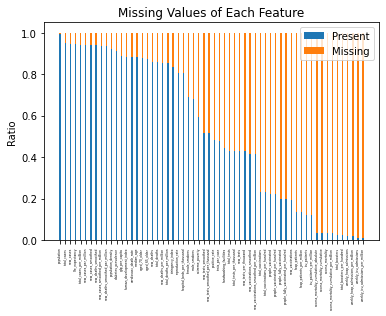

In [9]:
import matplotlib.pyplot as plt

num_features = len(missing_sorted)
labels = [" " for i in range(num_features)]
for i in range(num_features):
    labels[i] = missing_sorted[i][0]
missed = [missing_sorted[i][1] for i in range(num_features)]
exist = np.ones(num_features) - np.array(missed)
width = 0.25       # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots()
ax.bar(labels, exist, width,
           label='Present')
ax.bar(labels, missed, width, bottom=exist, label='Missing')
ax.set_ylabel('Ratio')
ax.set_title('Missing Values of Each Feature')
ax.set_xticklabels(labels, rotation=90, size=3)
ax.legend()
plt.savefig('../figures/missingvalues.png', dpi=300)
plt.show()


In [316]:
# draw a global map with each countries data
# using iso_code to locate
df_newest = df_updated[df_updated['date'] == '2021-12-04']
# if isnan, just replace with zero when visualization
# 12 countries have missing values
df_newest[np.isnan(df_newest['new_cases'])]['location']
#df_newest[target] = (np.log(df_newest[target])) ** 3

30900        Curacao
60697    Isle of Man
74964          Macao
Name: location, dtype: object

<Figure size 4900x2800 with 0 Axes>

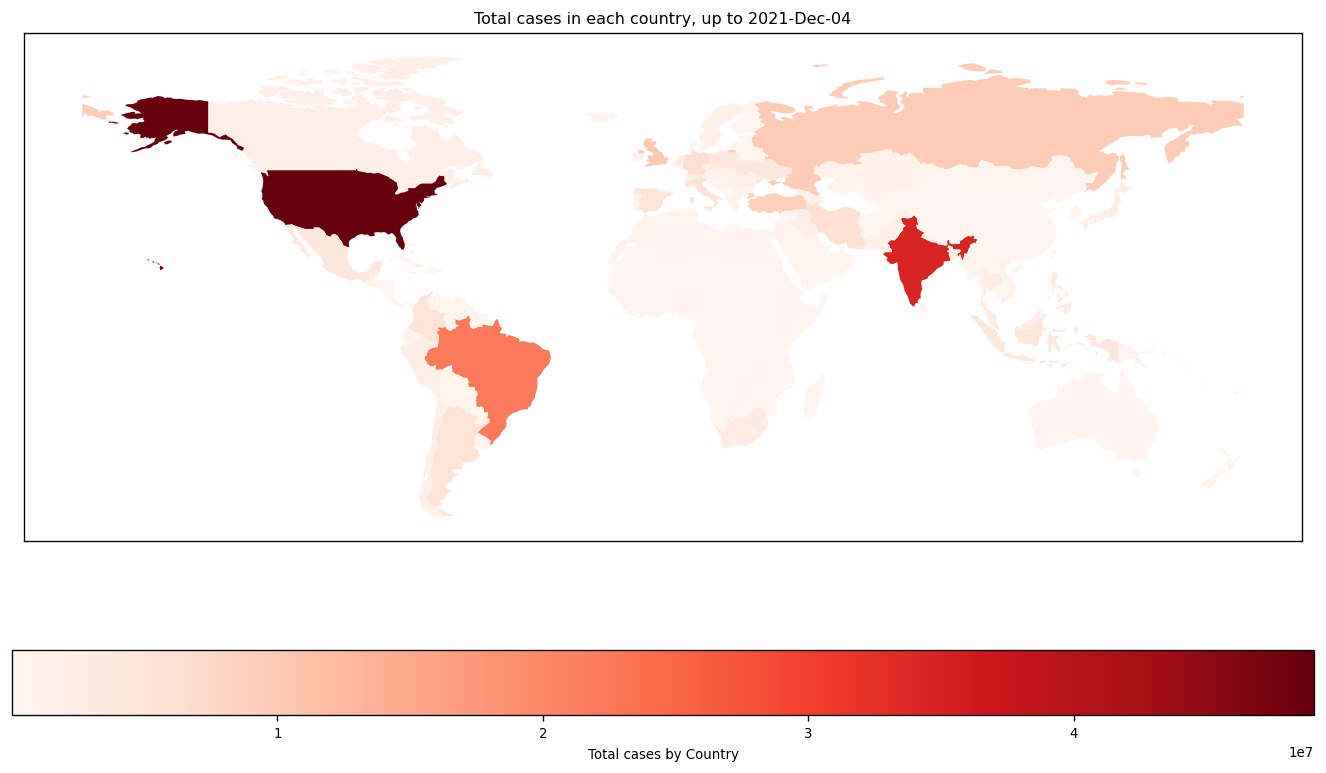

In [743]:
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)

plt.figure(figsize=(14, 8), dpi=350)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]

# always use iso_a3 as the column name
df_newest = df_newest.rename(columns={'iso_code': 'iso_a3'})
# merge the target data to the world map
world_merged = world.merge(df_newest, on='iso_a3')

world_merged.plot(column='total_cases',  figsize=(14, 8), cmap='Reds', legend=True, 
                  legend_kwds={'label': "Total cases by Country",
                        'orientation': "horizontal"})
plt.title("Total cases in each country, up to 2021-Dec-04")
plt.xticks([])
plt.yticks([])

plt.savefig('../figures/total-cases-heatmap.png')

In [151]:
df_pos = pd.read_csv("https://gist.githubusercontent.com/tadast/8827699/raw/f5cac3d42d16b78348610fc4ec301e9234f82821/countries_codes_and_coordinates.csv")
# df_pos.head()
df_pos = df_pos.rename(columns={'Alpha-3 code': 'iso_code', 'Latitude (average)': 'latitude', 'Longitude (average)':'longitude'})
df_pos.head()
special = ['AFR', 'ASI', 'CYN', 'EUN', 'EUR', 'INT', 'KOS', 'NAM', 'OCE', 'SAM', 'WRL']
for i in range(df_pos.shape[0]):
    df_pos.iloc[i]['iso_code'] = df_pos.iloc[i]['iso_code'][2:-1]
    #if df_pos.iloc[i]['iso_code'] in special:
     #   df_pos.iloc[i]['iso_code'] = 'OWID_' + df_pos.iloc[i]['iso_code']
    df_pos.iloc[i]['latitude'] = float(df_pos.iloc[i]['latitude'][2:-1])
    df_pos.iloc[i]['longitude'] = float(df_pos.iloc[i]['longitude'][2:-1])
df_newest = df_newest.merge(df_pos[["iso_code", 'latitude', 'longitude']], on='iso_code')
df_newest.head()


iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2021-10-06     155380.0       71.0   
1      ALB    Europe      Albania  2021-10-06     173190.0      572.0   
2      DZA    Africa      Algeria  2021-10-06     204171.0      125.0   
3      AND    Europe      Andorra  2021-10-06      15284.0       13.0   
4      AGO    Africa       Angola  2021-10-06      60448.0      553.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0              36.000        7220.0         6.0                2.286  ...   
1             532.571        2734.0         9.0                7.000  ...   
2             139.000        5838.0         7.0                4.714  ...   
3              10.714         130.0         0.0                0.000  ...   
4             552.143        1598.0        11.0                8.714  ...   

   handwashing_facilities  hospital_beds_per_thousand  life_expectancy  \
0                  37.746                        0.50            64.83   
1                     NaN                        2.89            78.57   
2                  83.741                        1.90            76.88   
3                     NaN                         NaN            83.73   
4                  26.664                         NaN            61.15   

   human_development_index  excess_mortality_cumulative_absolute  \
0                    0.511                                   NaN   
1                    0.795                                   NaN   
2                    0.748                                   NaN   
3                    0.868                                   NaN   
4                    0.581                                   NaN   

   excess_mortality_cumulative  excess_mortality  \
0                          NaN               NaN   
1                          NaN               NaN   
2                          NaN               NaN   
3                          NaN               NaN   
4                          NaN               NaN   

   excess_mortality_cumulative_per_million  latitude  longitude  
0                                      NaN      33.0       65.0  
1                                      NaN      41.0       20.0  
2                                      NaN      28.0        3.0  
3                                      NaN      42.5        1.6  
4                                      NaN     -12.5       18.5  

[5 rows x 67 columns]

In [152]:
df_original.describe()

total_cases      new_cases  new_cases_smoothed  total_deaths  \
count  1.163260e+05  116322.000000       115308.000000  1.054880e+05   
mean   1.458496e+06    6452.459045         6477.636120  3.684432e+04   
std    9.752308e+06   39277.832166        38897.463635  2.194798e+05   
min    1.000000e+00  -74347.000000        -6223.000000  1.000000e+00   
25%    2.028000e+03       3.000000            9.429000  6.900000e+01   
50%    2.122100e+04      93.000000          115.714000  6.100000e+02   
75%    2.177458e+05     929.000000          982.000000  5.281000e+03   
max    2.378788e+08  905948.000000       826439.429000  4.851942e+06   

          new_deaths  new_deaths_smoothed  total_cases_per_million  \
count  105641.000000        115308.000000            115714.000000   
mean      144.668216           132.021672             18066.139776   
std       788.808791           738.961266             30629.749159   
min     -1918.000000          -232.143000                 0.001000   
25%         0.000000             0.000000               354.835000   
50%         2.000000             1.714000              2777.336500   
75%        19.000000            15.857000             21995.937500   
max     17977.000000         14722.857000            219654.231000   

       new_cases_per_million  new_cases_smoothed_per_million  \
count          115710.000000                   114701.000000   
mean               83.809511                       83.911377   
std               195.092291                      164.311825   
min             -3125.829000                     -272.971000   
25%                 0.279000                        1.560000   
50%                10.733000                       14.878000   
75%                81.640000                       91.297000   
max              8620.690000                     3385.473000   

       total_deaths_per_million  ...  female_smokers  male_smokers  \
count             104889.000000  ...    84658.000000  83430.000000   
mean                 376.750786  ...       10.591724     32.740154   
std                  634.916009  ...       10.504537     13.506736   
min                    0.001000  ...        0.100000      7.700000   
25%                   10.426000  ...        1.900000     21.600000   
50%                   69.907000  ...        6.300000     31.400000   
75%                  457.711000  ...       19.300000     41.100000   
max                 5985.567000  ...       44.000000     78.100000   

       handwashing_facilities  hospital_beds_per_thousand  life_expectancy  \
count            54491.000000                98587.000000    116310.000000   
mean                50.734230                    3.023148        73.261204   
std                 31.752821                    2.452618         7.539178   
min                  1.188000                    0.100000        53.280000   
25%                 19.351000                    1.300000        67.920000   
50%                 49.839000                    2.400000        74.620000   
75%                 82.502000                    3.861000        78.740000   
max                100.000000                   13.800000        86.750000   

       human_development_index  excess_mortality_cumulative_absolute  \
count            108542.000000                           4322.000000   
mean                  0.726442                          28164.447617   
std                   0.150208                          82695.599668   
min                   0.394000                         -31959.400000   
25%                   0.602000                           -265.500000   
50%                   0.744000                           1266.100000   
75%                   0.848000                          17289.675000   
max                   0.957000                         693243.800000   

       excess_mortality_cumulative  excess_mortality  \
count                  4322.000000       4322.000000   
mean                      8.037462         15.032927   


In [318]:
#import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap

# a figure for target on 2021-10-10
# different dot size represent the number of people got infected, scale = 30000
#plt.figure(figsize=(14, 8), dpi=350)
#earth = Basemap()
#earth.drawcoastlines(color='#556655', linewidth=1)
#df_newest[target].replace(np.nan, 0)
#sz = [(df_newest.iloc[i][target]/30000) for i in range(df_newest.shape[0])]
#plt.scatter(df_newest['longitude'],df_newest['latitude'],s=sz, c='red', alpha=0.5, zorder=10)
#plt.title("Total cases for each country, up to 2021-Oct-06")
#plt.savefig('../figures/total-cases-map.png')

In [292]:
# histogram for number of total cases detected up to 2021-10-06
'''plt.figure()#dpi=300)
df_newest[target].plot.hist(log=True, bins = int(np.sqrt(df_newest.shape[0])) ) # log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df['capital-gain'])),50)
plt.xlabel('total cases')
plt.ylabel('number of countries')
#plt.savefig('../figures/total-cases-hist.png')
plt.show()'''

"plt.figure()#dpi=300)\ndf_newest[target].plot.hist(log=True, bins = int(np.sqrt(df_newest.shape[0])) ) # log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df['capital-gain'])),50)\nplt.xlabel('total cases')\nplt.ylabel('number of countries')\n#plt.savefig('../figures/total-cases-hist.png')\nplt.show()"

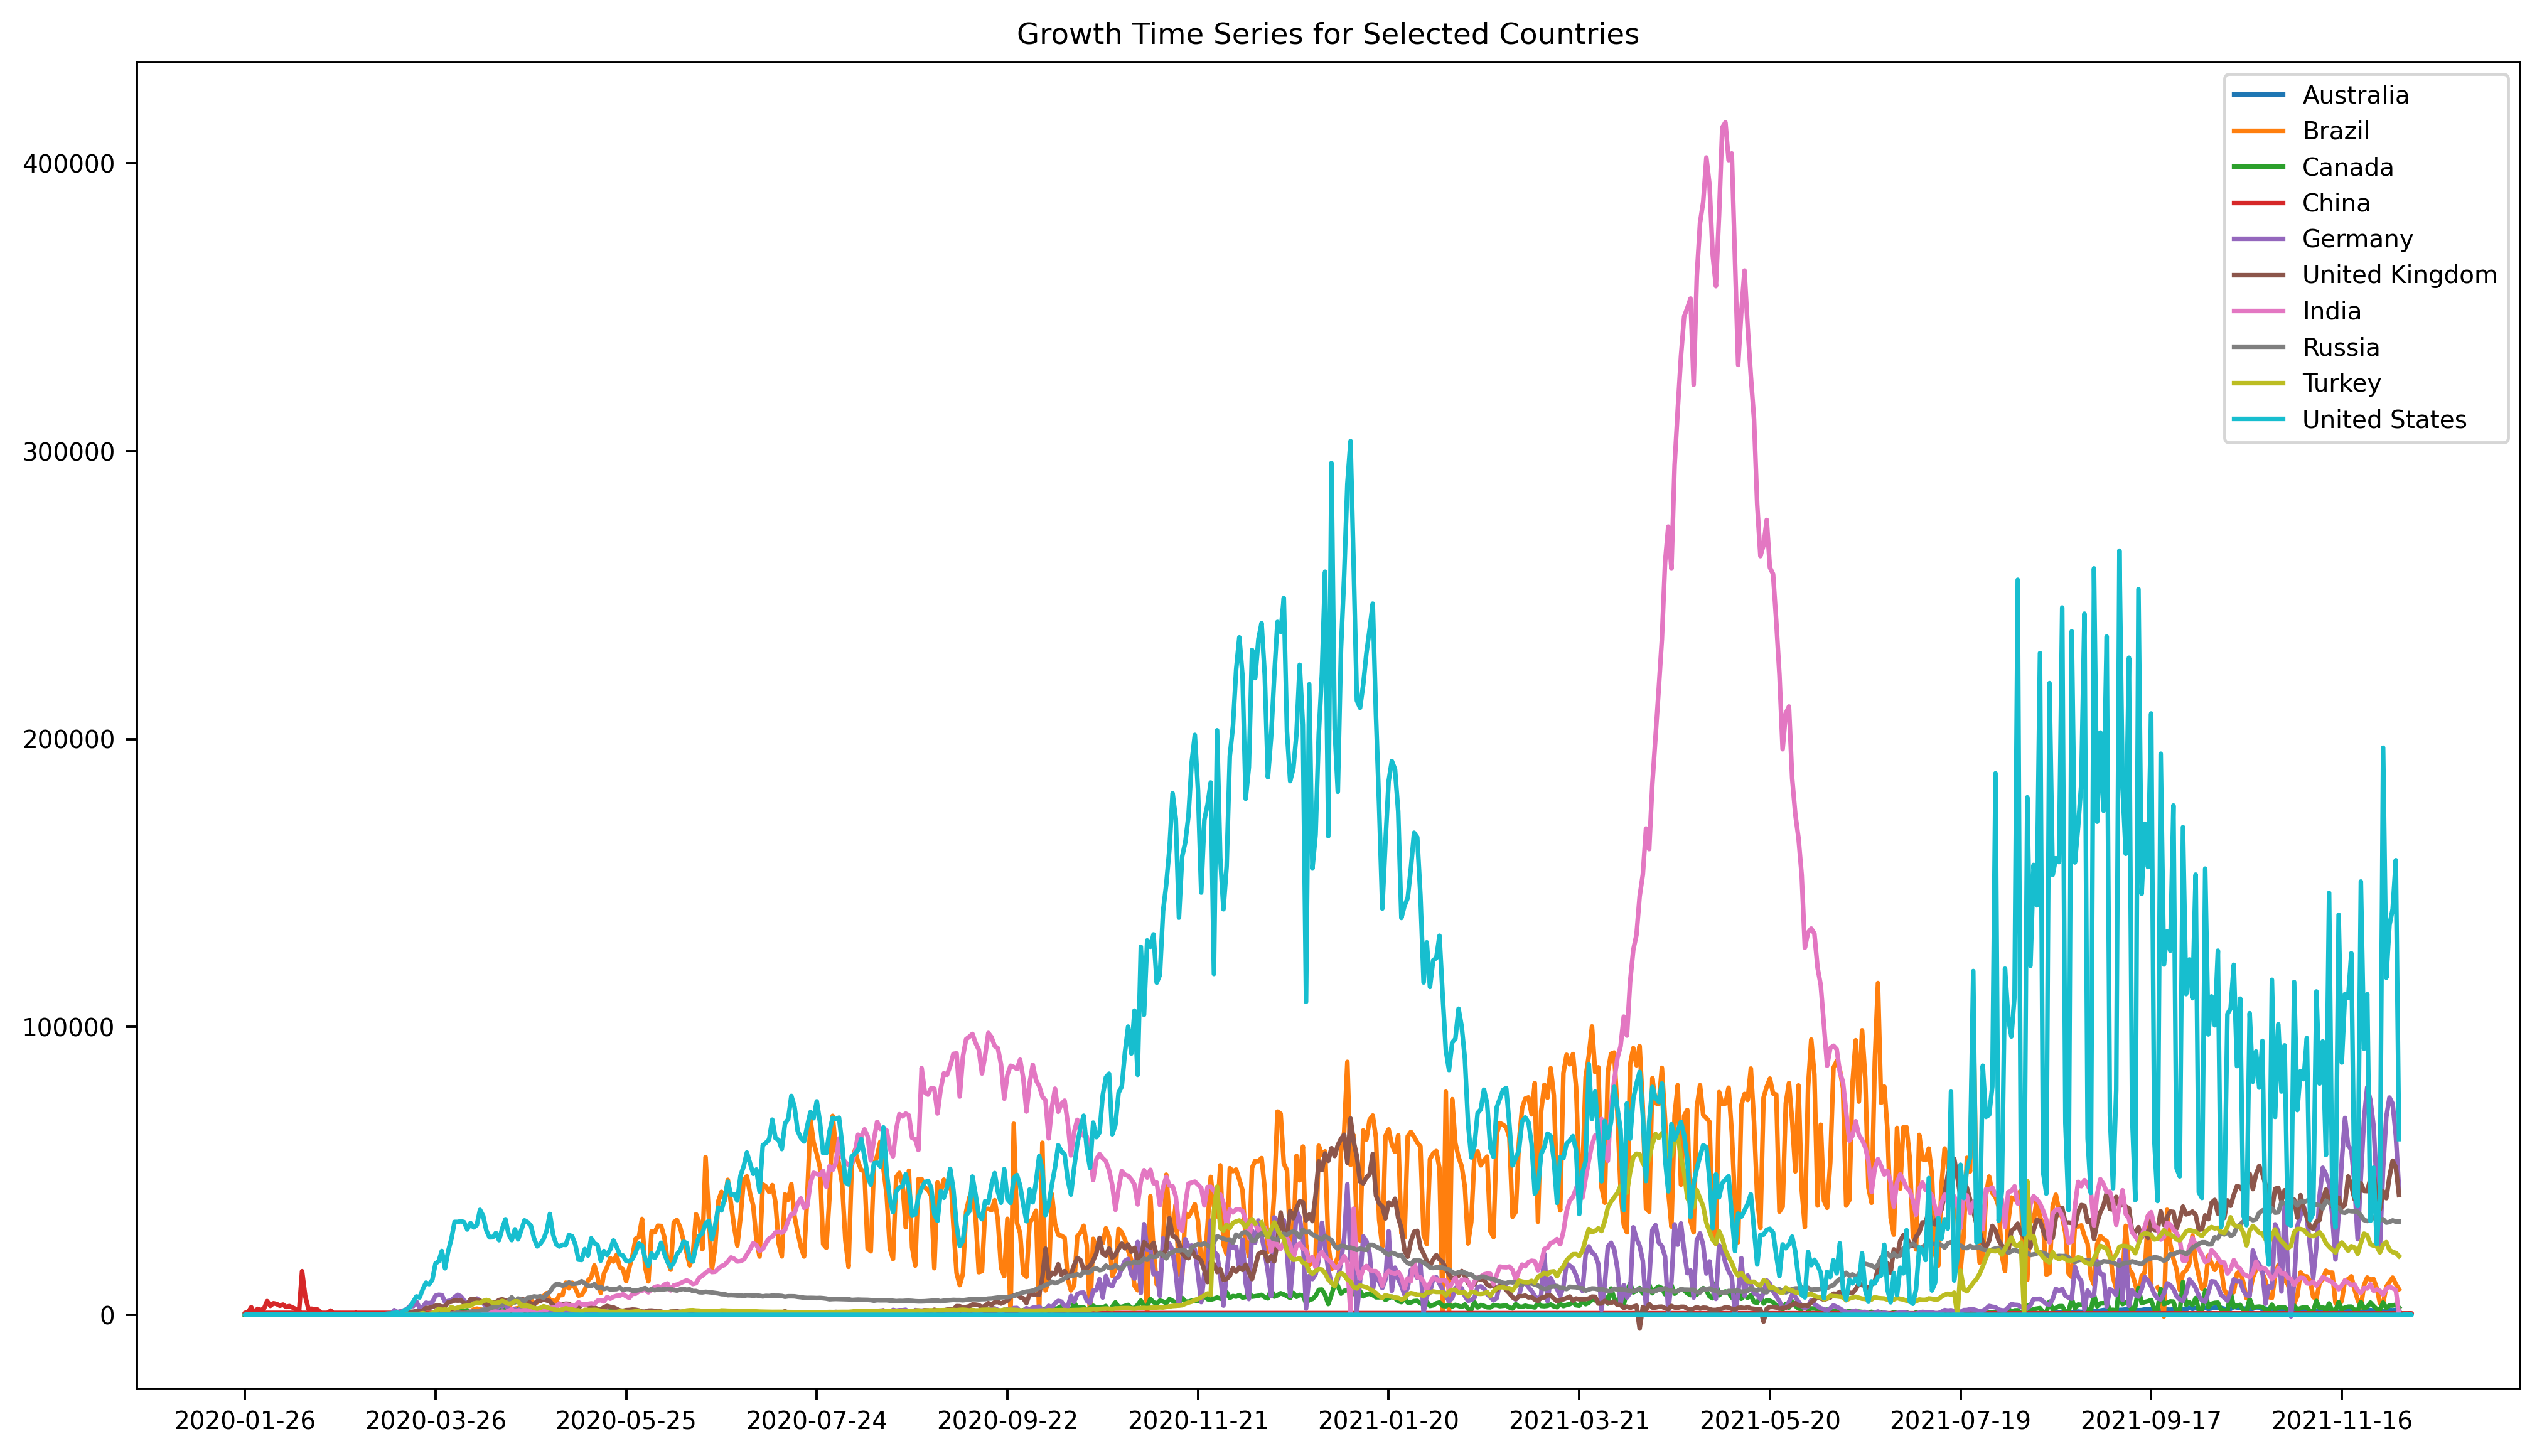

In [745]:
import matplotlib.ticker as ticker
# Some other figures using two columns

# total_cases are time series data
# df_USA = df_original[df_original['iso_code'] == 'USA']
# print(df_USA.shape)  #(628, 65)

df_by_state_all = df_updated.groupby("iso_code")

regions = df_by_state_all['iso_code'].unique()
len(df_by_state_all) # 233 different regions
selected_countries = ['CHN', 'USA', 'CAN', 'GBR', 'IND', 'DEU', 'BRA', 'RUS', 'TUR', 'AUS']

#plt.figure(figsize=(14, 8), dpi=350)
fig, ax = plt.subplots(1,1,figsize=(14, 8), dpi=350)
for key, grp in df_by_state_all: 
    if key in selected_countries:
        plt.plot(grp['date'], grp['new_cases'], label=str(grp.iloc[0]['location']))
# loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.set_xticks(ax.get_xticks()[::60])
plt.legend()    
plt.title("Growth Time Series for Selected Countries")
plt.savefig('../figures/new-cases.png')
#plt.show()

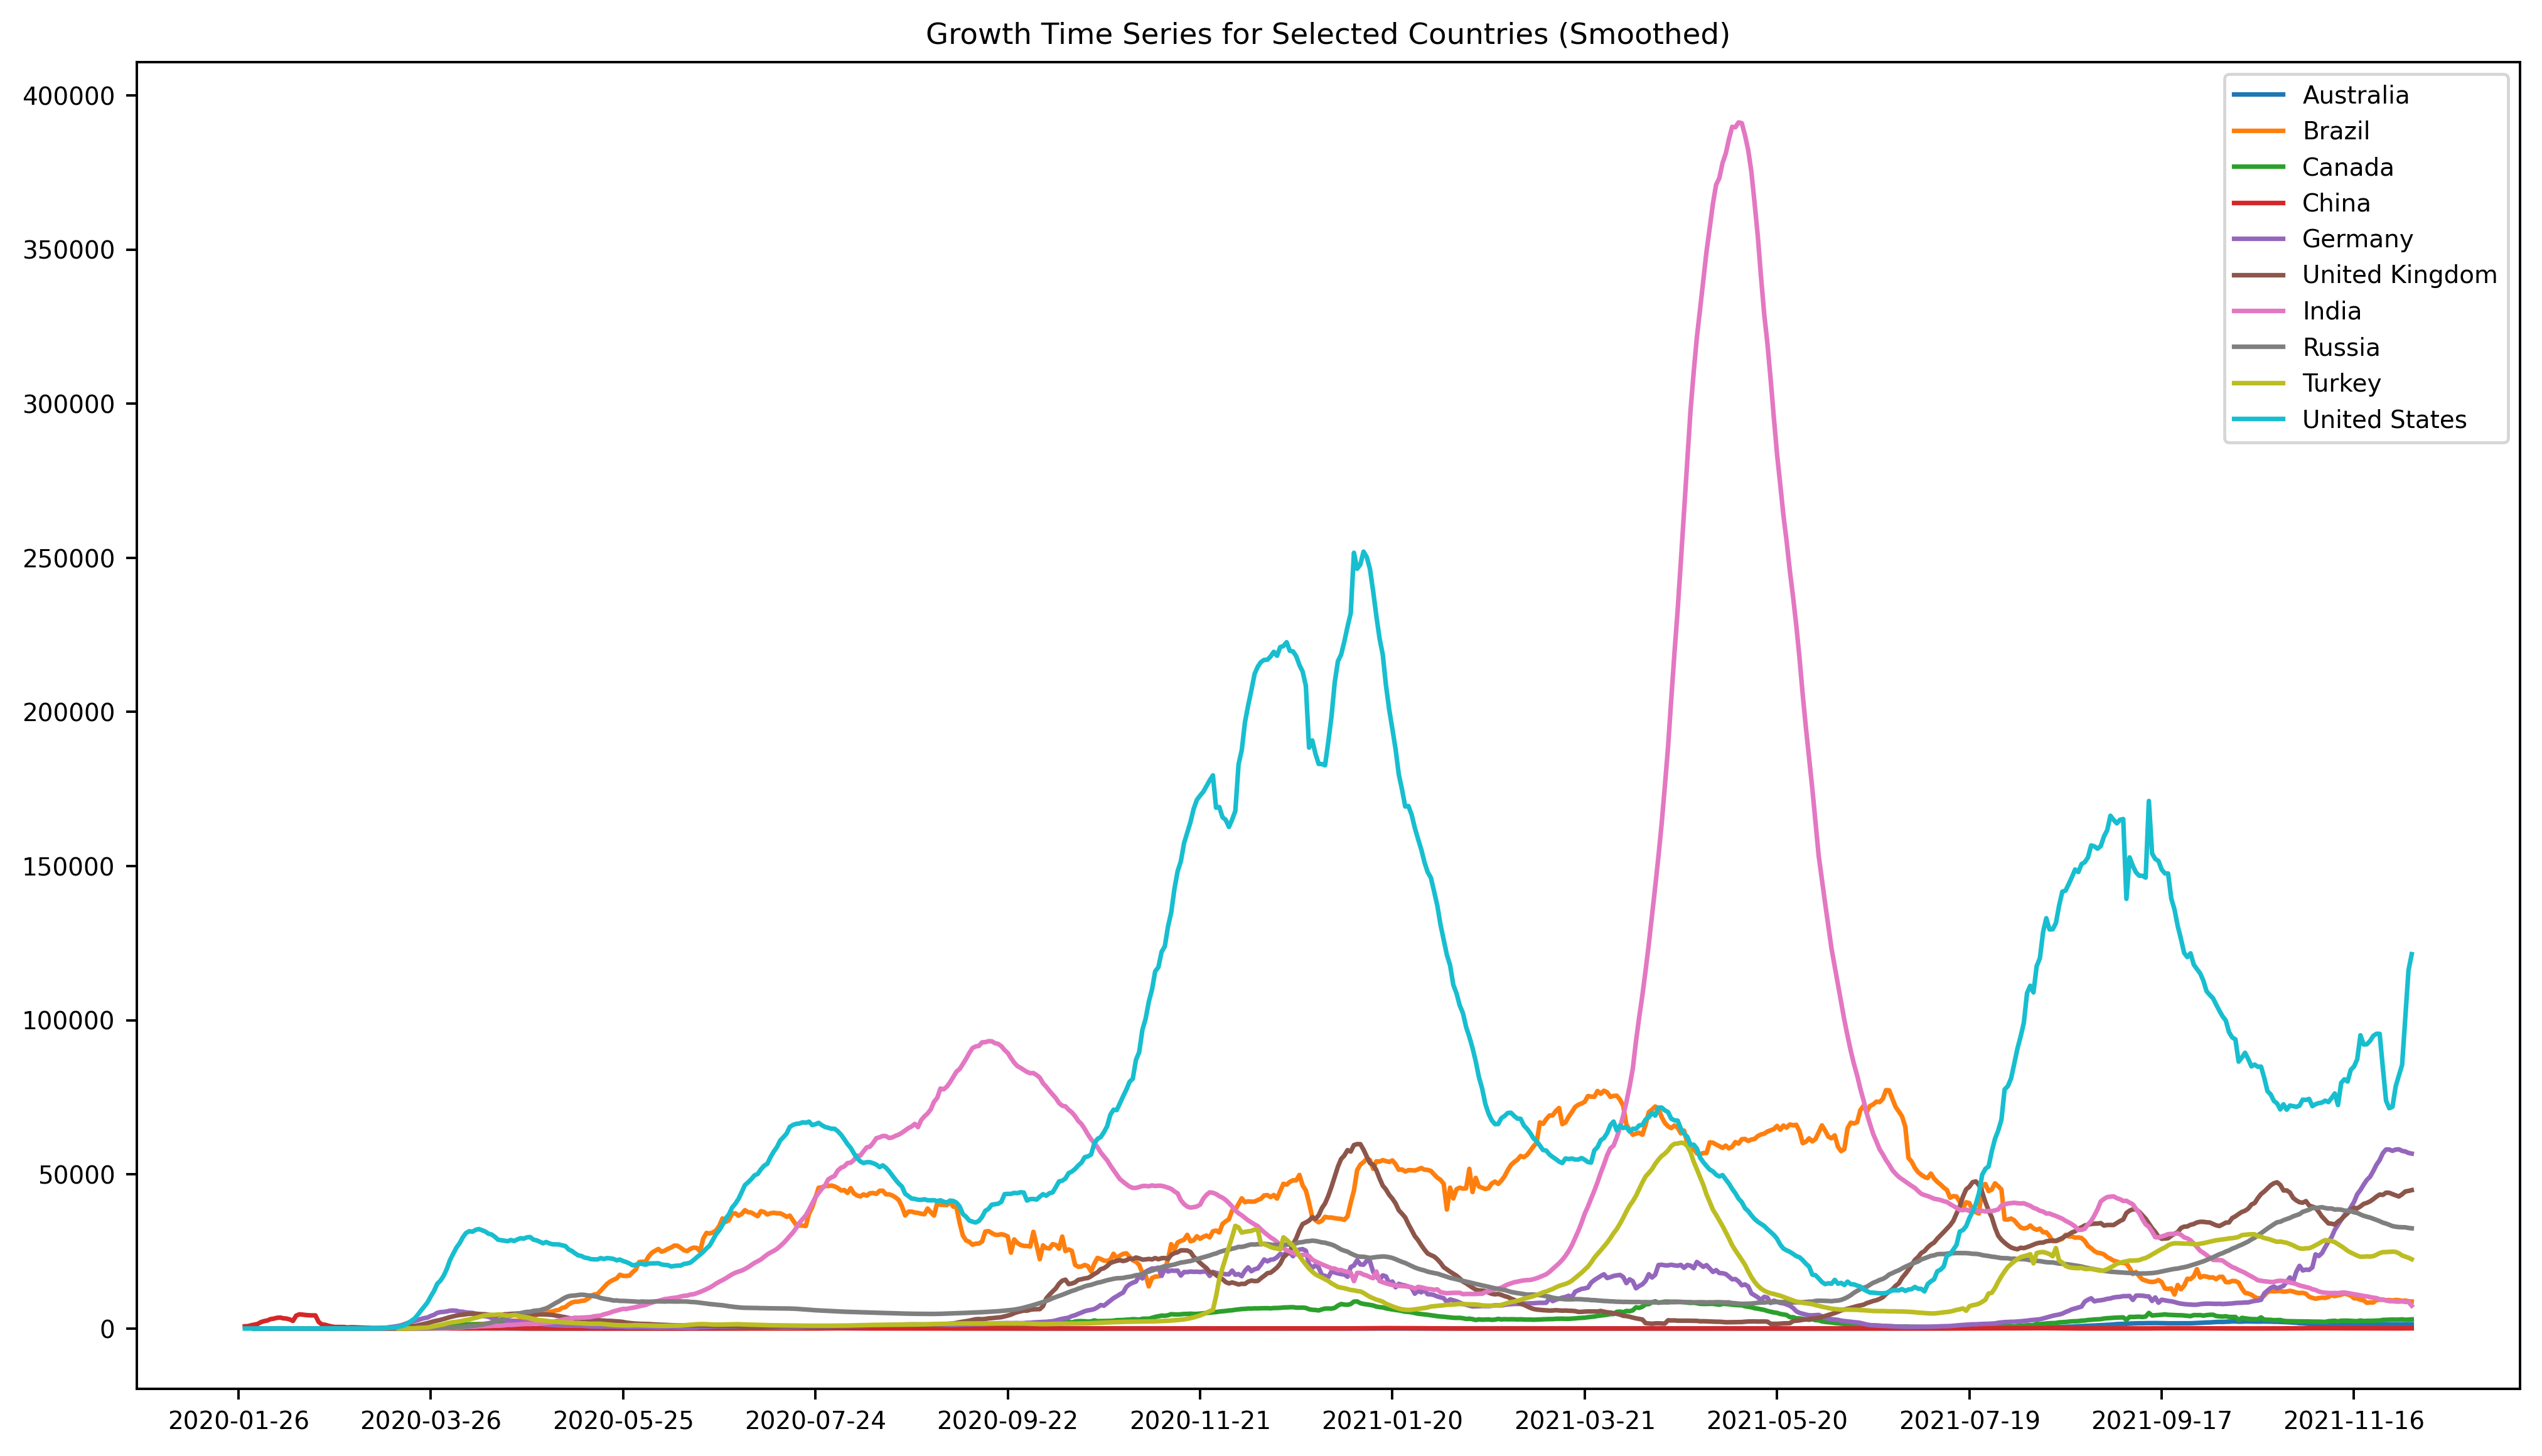

In [746]:
import matplotlib.ticker as ticker
#plt.figure(figsize=(14, 8), dpi=350)
fig, ax = plt.subplots(1,1,figsize=(14, 8), dpi=350)
for key, grp in df_by_state_all: 
    if key in selected_countries:
        plt.plot(grp['date'], grp['new_cases_smoothed'], label=str(grp.iloc[0]['location']))
# loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.set_xticks(ax.get_xticks()[::60])
plt.legend()    
plt.title("Growth Time Series for Selected Countries (Smoothed)")
plt.savefig('../figures/new-cases-smoothed.png')
#plt.show()

In [298]:
# scatter matrix for usa, vaccination and cases
#df_USA.plot.scatter('new_cases','new_vaccinations', alpha=0.5,s=10)
#plt.savefig('../figures/new_vac-new_cases-scatter.png',dpi=300)
#plt.show()

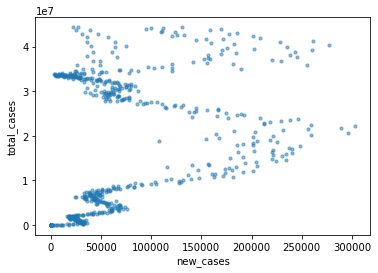

In [158]:
df_USA.plot.scatter('new_cases',target, alpha=0.5,s=10) 
plt.savefig('../figures/total_cases-new_cases-scatter.png',dpi=300)
plt.show()
# this figure shows strong relationship between the two variables

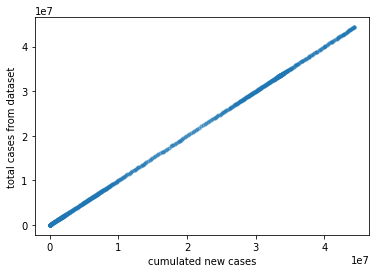

In [179]:
total_manual = []
cur = 0
for i in range(df_USA.shape[0]):
    new_case =  df_USA.iloc[i]['new_cases']
    if not np.isnan(new_case):
        cur += new_case
    total_manual.append(cur)
plt.scatter(total_manual, df_USA[target], alpha=0.5,s=10)
plt.xlabel('cumulated new cases')
plt.ylabel('total cases from dataset')
plt.savefig('../figures/total_cases-manual-scatter.png',dpi=300)
plt.show()

In [186]:
s1 = pd.Series(list(df_USA[target]))
s2 = pd.Series(total_manual)
print(s1.corr(s2))

1.0


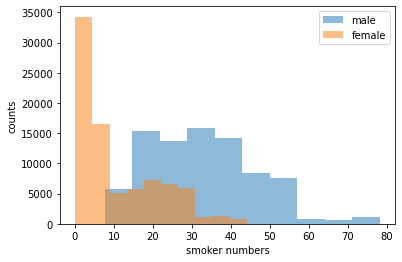

In [197]:
#df_original['female_smokers'].value_counts()
plt.hist(df_original['male_smokers'], alpha=0.5, label='male')
plt.hist(df_original['female_smokers'], alpha=0.5, label='female') # log=True, bins = np.logspace(np.log10(1),np.log10(np.max(df['capital-gain'])),50)
plt.xlabel('smoker numbers')
plt.ylabel('counts')
plt.legend(loc='upper right')
plt.savefig('../figures/gender_smokers.png', dpi=300)
plt.show()

# Preprocess data
The data is not iid, but have group structure as well as time series properties. So what I want to do is focus on only a few countries, and use times series modeling. At the same time, not all the columns are selected, as a lot are coorelated or can be inferred from each other, e.g. new_vaccinations is the first-order difference of total_vaccinations. Also, new_cases should not be included as a feature when preciting future total_cases.

However, auto-regression may be more important in this project. So in the following part, I will not only perform group splitting on the whole dataset, but also just focuse on independent specific countries, predicting their future trend using time series splitting. In the previous steps, I have already grouped the data by countries, and I'll select a few countries of interest.

In [90]:
# Coorelation/mutual-info test, feature selection
from sklearn.feature_selection import mutual_info_regression


# Here I use zero-inpution, just a rough assessment for each feature
# This still makes sense because in this dataset missing data can be from non-increment of each day
# e.g. Some countries' deaths cases are nan because they have not reported any case
y = df_original[target].replace(np.nan, 0)
df_ftr_original = df_original[ftr_original].replace(np.nan, 0)
mutual_info = mutual_info_regression(df_ftr_original, y)

In [819]:
def splitOtherTest(df, iso, target):
    ftr_original = list(data)
    ftr_original.remove(target)
    ftr_original.remove('positive_rate')
    no_use_death = ['total_deaths', 'new_deaths_smoothed', 'total_deaths_per_million', 
                    'new_deaths_per_million', 'new_deaths_smoothed_per_million']
    no_use_test = ['total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand',
                  'new_tests_smoothed', 'new_tests_smoothed_per_thousand']
    for ftr in no_use_death:
        ftr_original.remove(ftr)
    for ftr in no_use_test:
        ftr_original.remove(ftr)
    ftr_select = []
    for ftr in ftr_original:
        if ftr.find('cases') == -1:
            ftr_select.append(ftr)
    #print(len(ftr_select)) 
    
    df_by_state = df.groupby("iso_code")
    df_choose = df_by_state.get_group(iso).set_index('date')
    df_choose[target].replace(np.nan, 0, inplace=True)
    otherend = "2021-10-10"
    teststart = "2021-10-11"
    #df_other = df_choose.index
    X_other = df_choose.loc[:otherend][ftr_select]
    X_test = df_choose.loc[teststart:][ftr_select]
    #print(df_other, df_test)
    Y_other = df_choose.loc[:otherend][target]
    Y_test = df_choose.loc[teststart:][target]
    return X_other, Y_other, X_test, Y_test

In [330]:
#for i in range(len(ftr_original)):
#    print(ftr_original[i], mutual_info[i])

An insteresting phenonmenon here is that, though we already know that total_cases can just be calculated with new_cases, the mutual information for this index is not large enough. To predict total cases, we are actually predicting new_cases each day, and adding the data to the total_cases of one day before. So we cannot put it into our feature set. 

In [299]:
import warnings
warnings.filterwarnings('ignore')

There are 54 features being selected:
    65 Columns at first, with 4 columns regarding indexing are not included in ftr_original, test places and target removed and 5 regarding new cases deleted from ftr_original.

# Time series

In [401]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf



def plotACF(ts):
    plt.rcParams.update({'figure.figsize':(9,7)})#, 'figure.dpi':120})
    fig, axes = plt.subplots(3, 2, sharex=True)
    axes[0, 0].plot(ts); axes[0, 0].set_title('Original Series')
    plot_pacf(ts, ax=axes[0, 1])
    
    diff1 = np.diff(ts)
    axes[1, 0].plot(diff1); axes[1, 0].set_title('1st Order Difference')
    plot_pacf(diff1, ax=axes[1, 1])
    
    diff2 = np.diff(diff1)
    axes[2, 0].plot(diff2); axes[2, 0].set_title('2nd Order Difference')
    plot_pacf(diff2, ax=axes[2, 1])
    plt.xticks([])
    plt.savefig('../figures/PACF.png', dpi=300)
    plt.show()
    
    
    pd.plotting.autocorrelation_plot(ts, label='Original Series')
    pd.plotting.autocorrelation_plot(diff1, label='1st Order Difference')
    pd.plotting.autocorrelation_plot(diff2, label='2nd Order Difference')
    plt.legend()
    plt.savefig('../figures/ACF.png', dpi=300)
    plt.show()
    
    
def findBestpq(ts):
    acf_series = acf(np.diff(ts)) # MA = 0
    pacf_series = pacf(np.diff(ts)) # AR = 2

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11753.814, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11921.487, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11866.373, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11891.115, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11920.820, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11723.814, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11772.451, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11718.068, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11723.506, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11719.288, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11708.797, Time=0.47 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11707.245, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11712.608, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11714.101, Time=0.60 sec
 ARIMA(1,1,3)(0,0,0

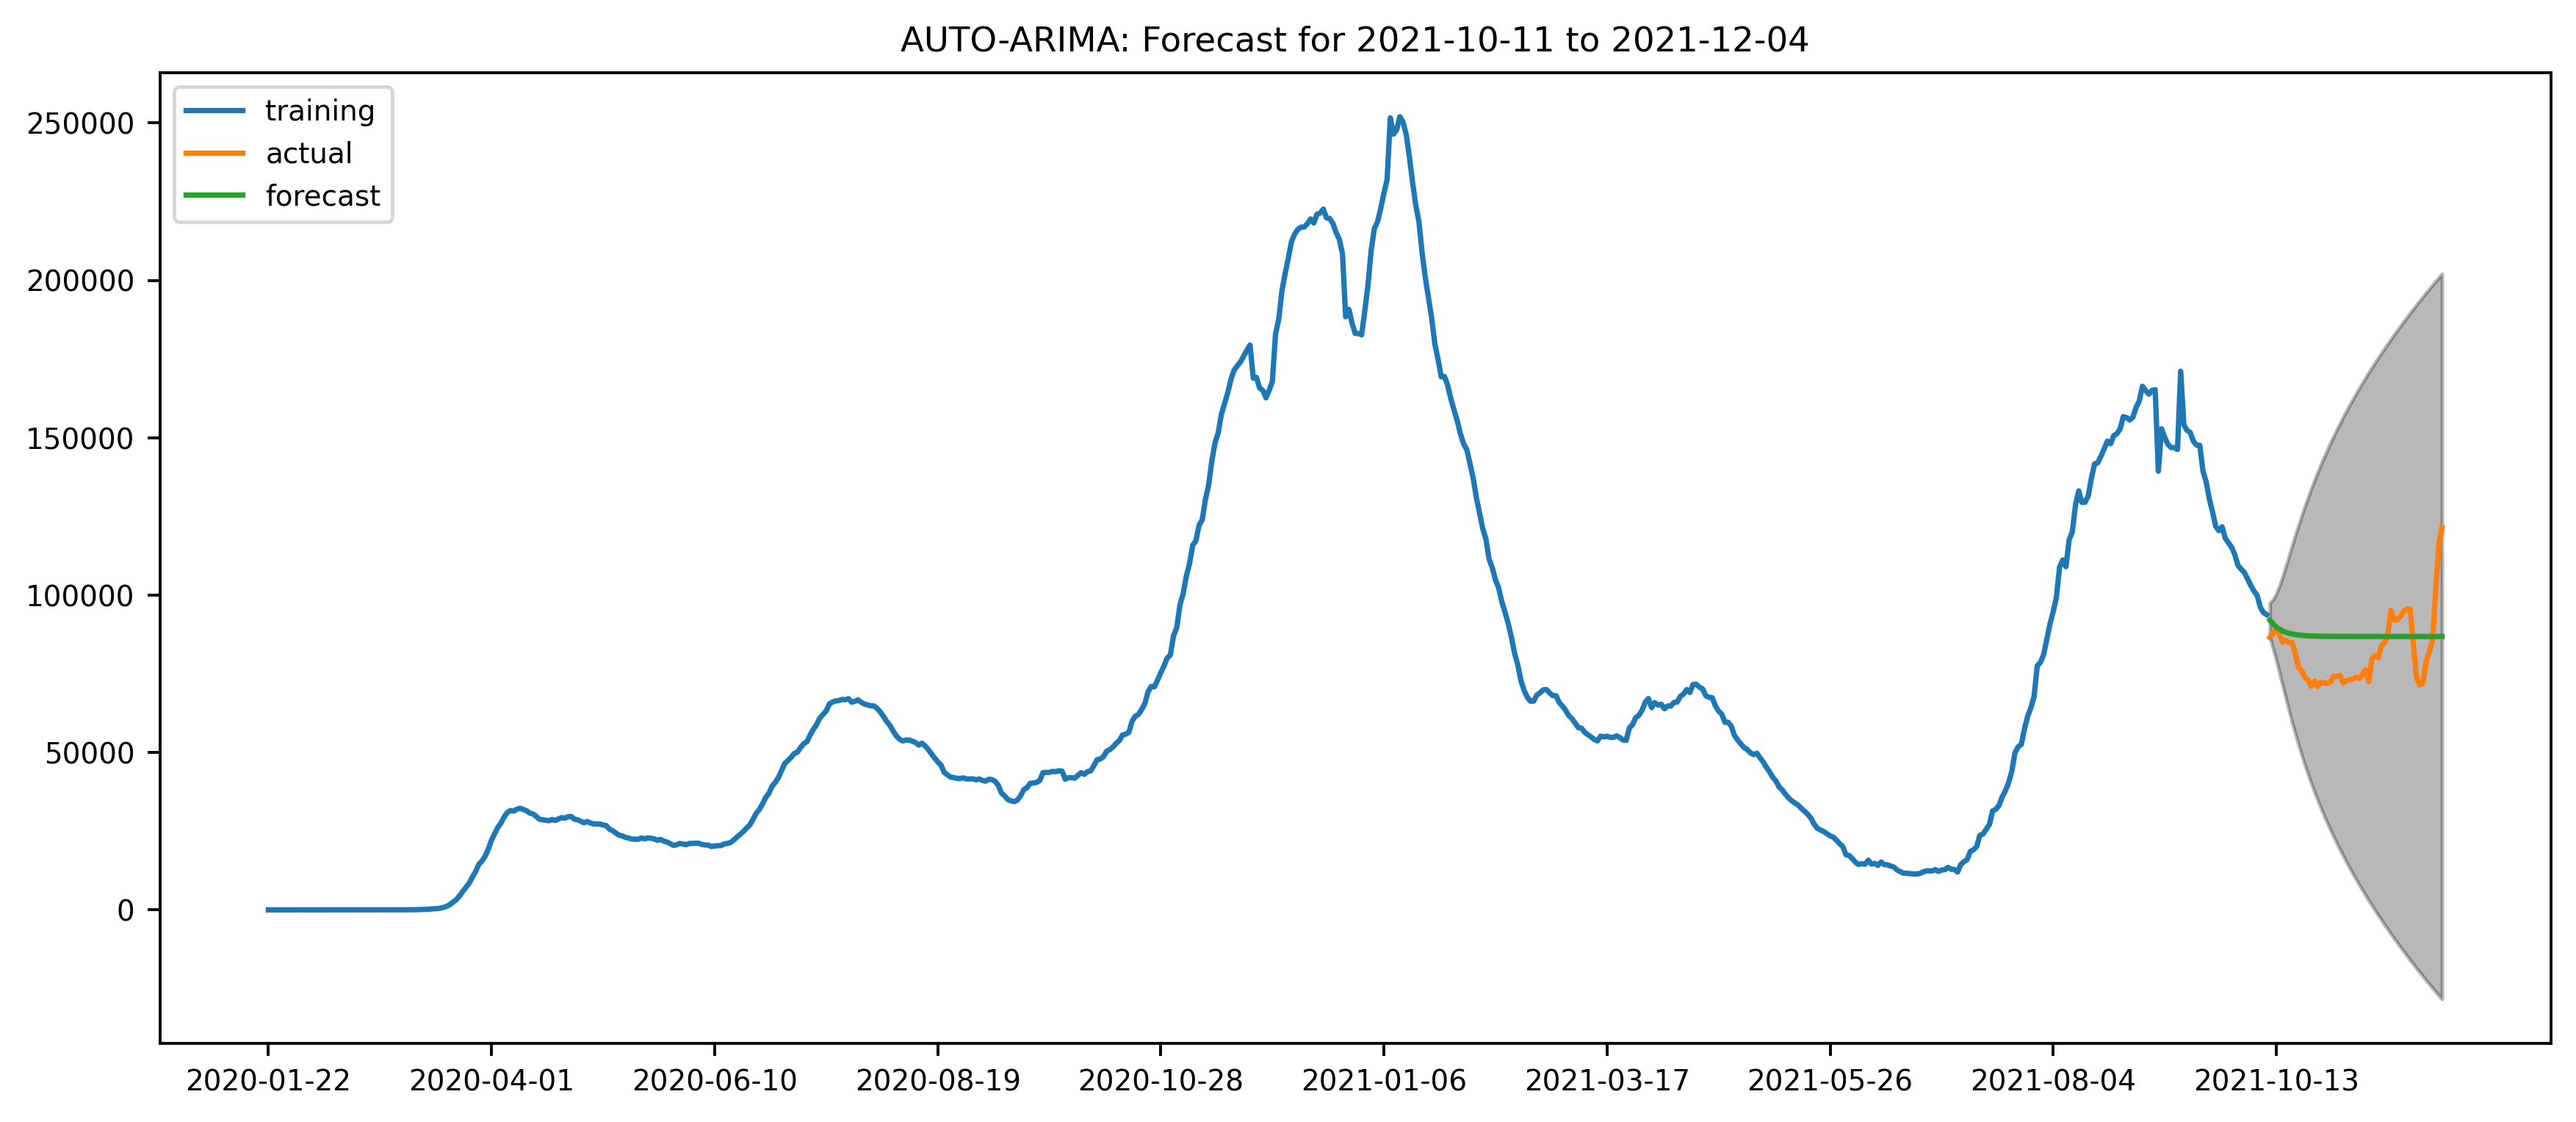

Test RMSE: 11977.687


In [898]:
import pmdarima as pm
import matplotlib.ticker as ticker

def ARIMA_baseline(ts, ts_test):
    #plotACF(ts)
    # findBestpq(ts)
    autoarima = pm.auto_arima(ts, start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_d=2, max_q=4, 
                         start_P=0, seasonal=False,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
    print(autoarima.summary())
    filename = '../results/ARIMA.sav'
    pickle.dump(autoarima, open(filename, 'wb'))
    fitted, confint = autoarima.predict(n_periods=len(ts_test), return_conf_int=True)

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=ts_test.index)
    lower_series = pd.Series(confint[:, 0],index=ts_test.index)
    upper_series = pd.Series(confint[:, 1],index=ts_test.index)
    fig, ax = plt.subplots(1,1,figsize=(12, 5), dpi=350)
    # Plot
    #plt.figure(figsize=(12,5), dpi=100)
    plt.plot(ts, label='training')
    plt.plot(ts_test, label='actual')
    plt.plot(fitted_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)

    plt.title("AUTO-ARIMA: Forecast for 2021-10-11 to 2021-12-04")
    ax.set_xticks(ax.get_xticks()[::70])
    plt.savefig('../figures/ARIMA-Predict.png', dpi=300)
    plt.show()
    
    rmse = np.sqrt(mean_squared_error(ts_test, fitted_series))
    r2 = r2_score(ts_test, fitted_series)
    print('Test RMSE: %.3f' % rmse)
    
X_USA, Y_USA, X_USA_test, Y_USA_test = splitOtherTest(df_updated, 'USA', "new_cases_smoothed")
ARIMA_baseline(Y_USA, Y_USA_test)

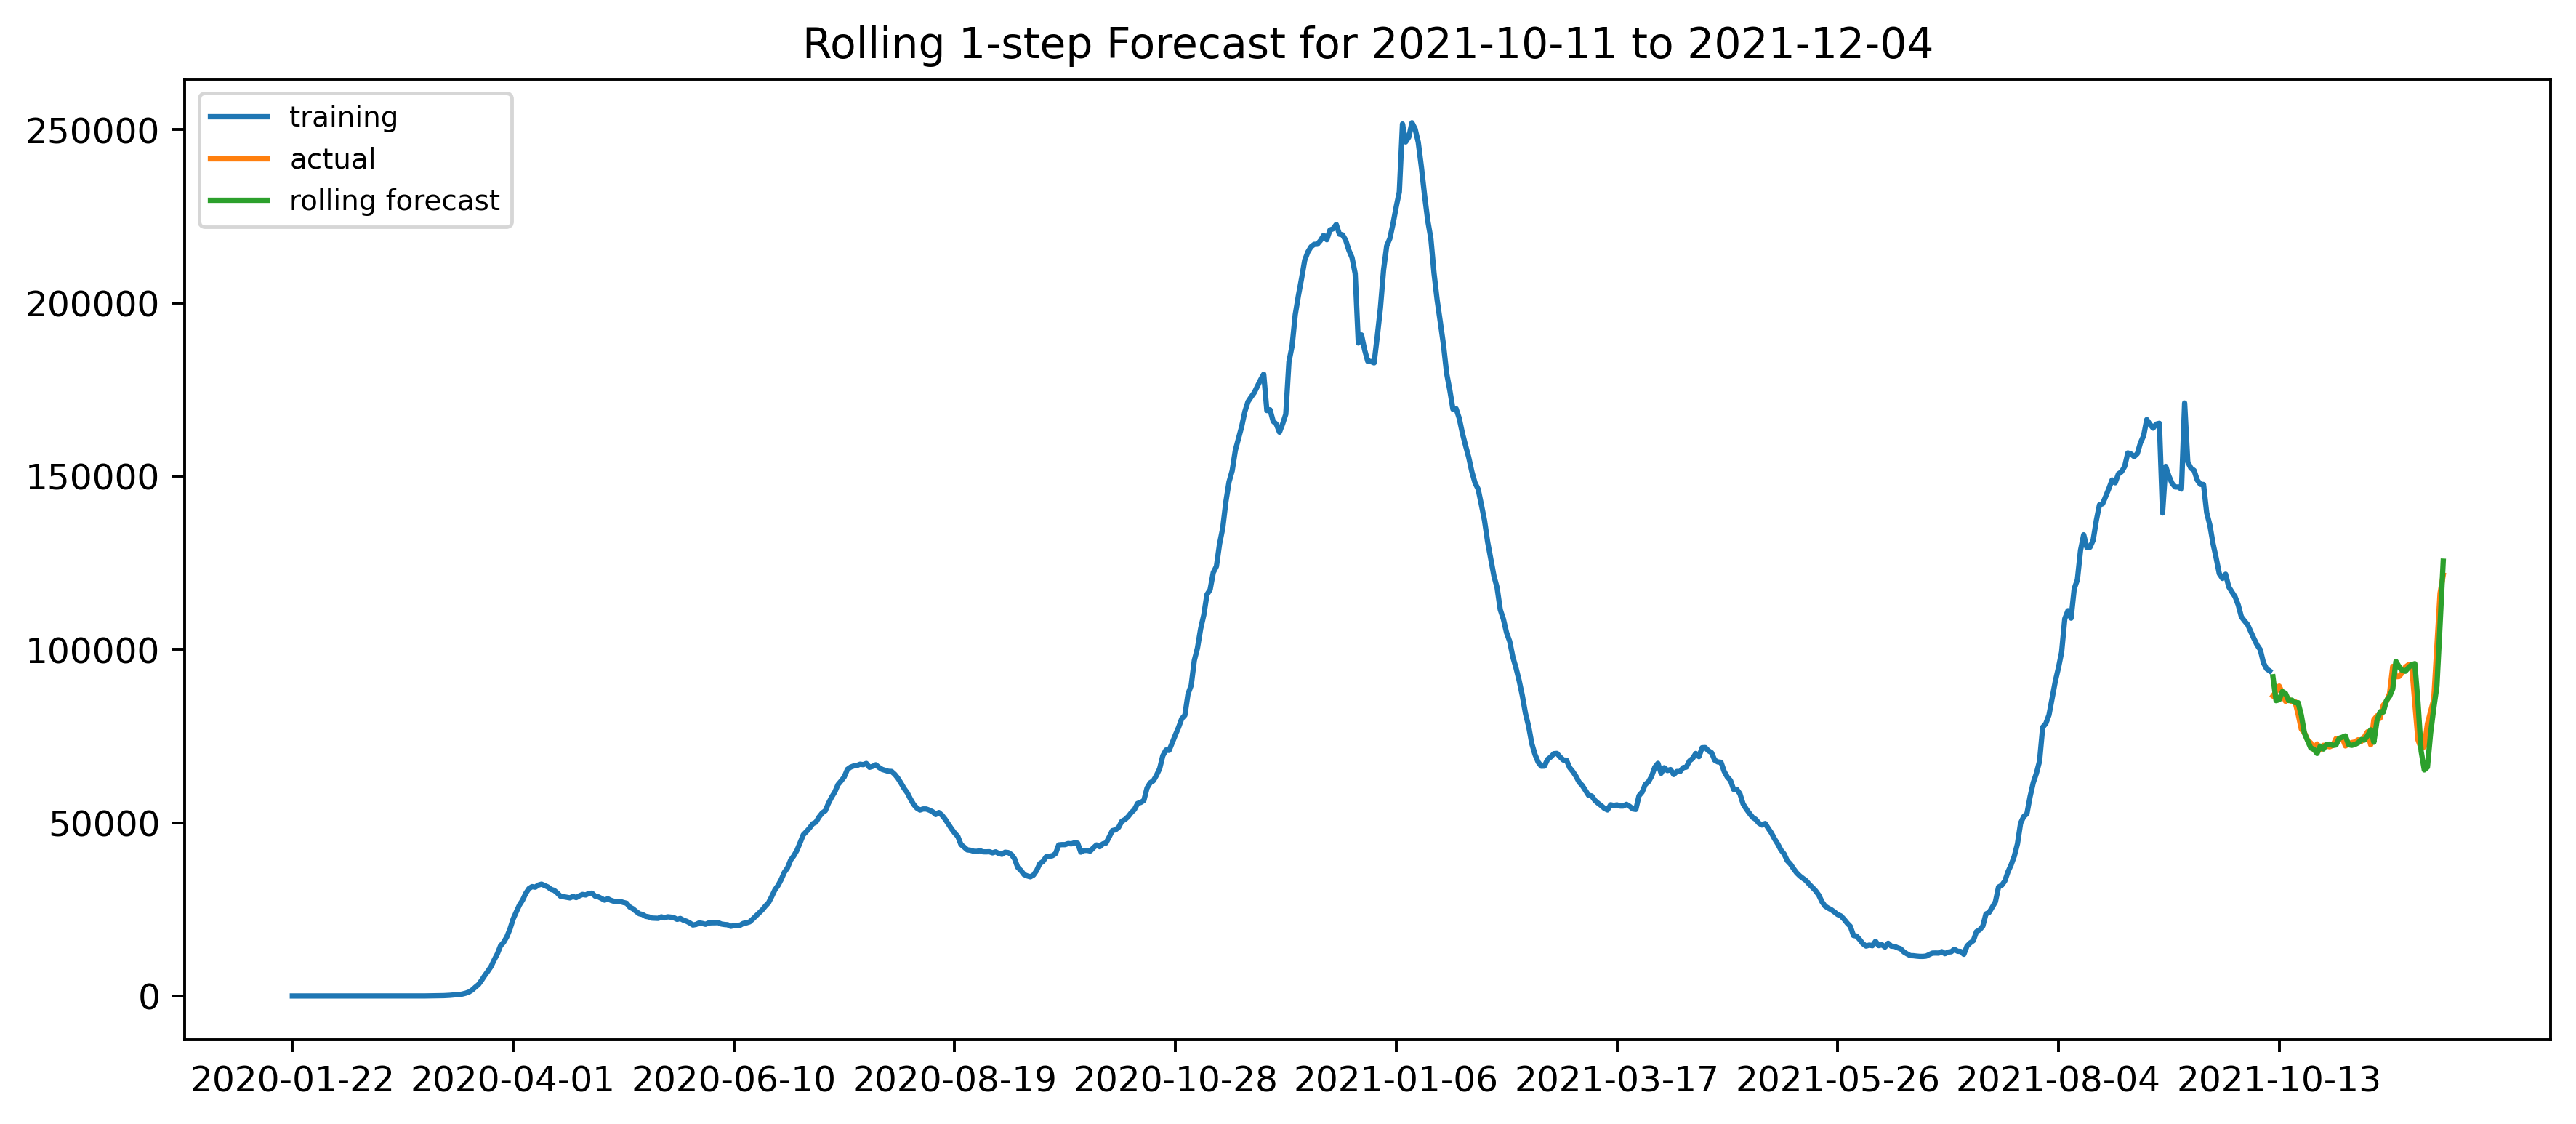

In [422]:
history = [x for x in Y_USA]
predictions = list()
# walk-forward validation
for t in range(len(Y_USA_test)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = Y_USA_test[t]
    history.append(obs)

fitted_series = pd.Series(predictions, index=Y_USA_test.index)
fig, ax = plt.subplots(1,1,figsize=(12, 5), dpi=350)
plt.plot(Y_USA, label='training')
plt.plot(Y_USA_test, label='actual')
plt.plot(fitted_series, label='rolling forecast')

plt.legend(loc='upper left', fontsize=8)

plt.title("Rolling 1-step Forecast for 2021-10-11 to 2021-12-04")
ax.set_xticks(ax.get_xticks()[::70])
plt.savefig('../figures/ARIMA-Predict-Onestep.png', dpi=300)
plt.show()

In [423]:
rmse = np.sqrt(mean_squared_error(Y_USA_test, fitted_series))
r2 = r2_score(Y_USA_test, fitted_series)
print('Test RMSE: %.3f' % rmse)
print('Test R2: %.3f' % r2)

Test RMSE: 4220.165
Test R2: 0.847


# Other models

### Kfold Cross Validation Illustration

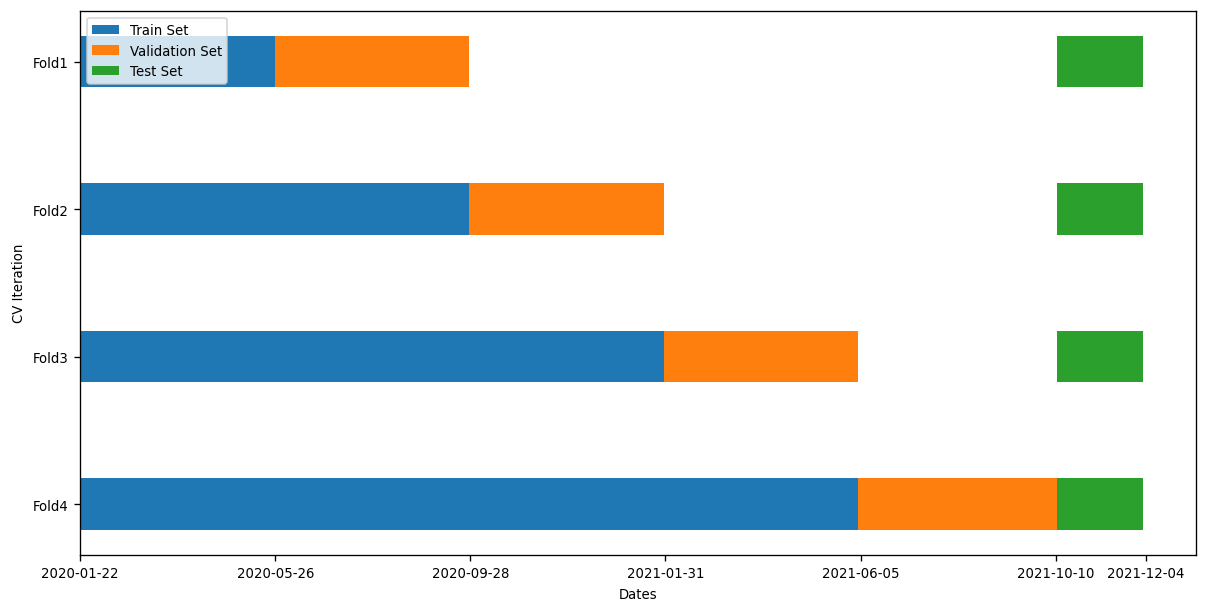

In [762]:
train = [125,250,375,500]
val = [125, 125,125,128]
labels= ['Fold1', 'Fold2', 'Fold3', 'Fold4']
test = [55,55,55,55]
dates = ['2020-01-22','2020-05-26', '2020-09-28','2021-01-31','2021-06-05', '2021-10-10', '2021-12-04']
width = 0.35
fig, ax = plt.subplots(figsize=(12, 6))

ax.barh(labels, train, width, label='Train Set')
ax.barh(labels, val, width, left=train,
       label='Validation Set')
ax.barh(labels, test, width, left=[628, 628, 628, 628],
       label='Test Set')

ax.set_ylabel('CV Iteration')
ax.set_xlabel('Dates')
#ax.set_title('Split Time Series for Cross Validation')
plt.legend(loc='upper left', fontsize=8)
pos = [0, 125/683, 250/683, 375/683, 500/683, 625/683, 1]
xticks_pos = [pos[i]*685 for i in range(len(pos))]
plt.xticks(xticks_pos, dates)
plt.gca().invert_yaxis()
plt.savefig('../figures/Cross-validation.png', dpi=300)
plt.show()

In [821]:
def printMissing(df):
    perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
    print('fraction of missing values in features:')
    print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
    print('data types of the features with missing values:')
    print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
    frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
    print('fraction of points with missing values:',frac_missing)

X_USA, Y_USA, X_USA_test, Y_USA_test = splitOtherTest(df_updated, 'USA', "new_cases_smoothed")

to_drop = []
for ftr in X_USA.columns:
    if X_USA[ftr].isnull().sum(axis=0)/X_USA.shape[0] > 0.5:
        to_drop.append(ftr)
X_USA.drop(columns=to_drop, inplace=True)
X_USA_test.drop(columns=to_drop, inplace=True)
X_USA.shape
X_USA_xgb = X_USA.copy()
X_USA_test_xgb = X_USA_test.copy()

In [822]:
X_USA.replace(np.nan, 0, inplace=True)
X_USA_test.replace(np.nan, 0, inplace=True)
printMissing(X_USA_test)
printMissing(X_USA_test_xgb)

fraction of missing values in features:
Series([], dtype: float64)
data types of the features with missing values:
Series([], dtype: object)
fraction of points with missing values: 0.0
fraction of missing values in features:
reproduction_rate    0.054545
new_tests            0.090909
tests_per_case       0.090909
stringency_index     0.072727
dtype: float64
data types of the features with missing values:
reproduction_rate    float64
new_tests            float64
tests_per_case       float64
stringency_index     float64
dtype: object
fraction of points with missing values: 0.09090909090909091


In [823]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


def MLpipe_KFold_RMSE(X, Y, X_test, Y_test, ML_algo, param_grid, n_folds=4):
    training_total = len(Y)
    each_cv = (int)(training_total / (n_folds+1))
    
    def RMSE(y_true, y_predict):
        return np.sqrt(mean_squared_error(y_true, y_predict))
    
    models = []
    val_scores = []
    scalers = []
    
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        #print('   ',params) 
        # set the random state for reproducibility
        try:
            ML_alg = ML_algo(**params, random_state = 42)
        except:
            ML_alg = ML_algo(**params)
        for j in range(n_folds):
            train_index = (j+1) * each_cv
            val_index = (j+2) * each_cv
            if j == n_folds - 1:
                val_index = training_total
            X_train, X_val = X[: train_index], X[train_index:val_index]
            Y_train, Y_val = Y[: train_index], Y[train_index:val_index]
            
            scaler = StandardScaler()
            X_train_prep = scaler.fit_transform(X_train)
            scalers.append(scaler)
            X_val_prep = scaler.transform(X_val)
            
            ML_alg.fit(X_train_prep, Y_train)  # With K-Fold

            models.append(ML_alg) # save it
            # calculate train and validation accuracy scores
            Y_val_pred = ML_alg.predict(X_val_prep)
            val_scores.append(RMSE(Y_val,Y_val_pred))
            #print('   ',val_scores[p])
    
    pos = np.argmin(val_scores)
    print('Mean val score:', np.mean(val_scores))
    print('Standard deviation:', np.std(val_scores))
    print("Best params:", ParameterGrid(param_grid)[pos//n_folds])
    best_model = models[pos]
    best_scaler = scalers[pos]
    Y_test_pred = best_model.predict(best_scaler.transform(X_test)) 
    print('Best Test RMSE:', RMSE(Y_test, Y_test_pred))

    return best_model, best_model.predict(best_scaler.transform(X)), Y_test_pred 

## Linear Regression

Mean val score: 28021.595809284514
Standard deviation: 11681.584795266335
Best params: {}
Best Test RMSE: 28912.463891747404


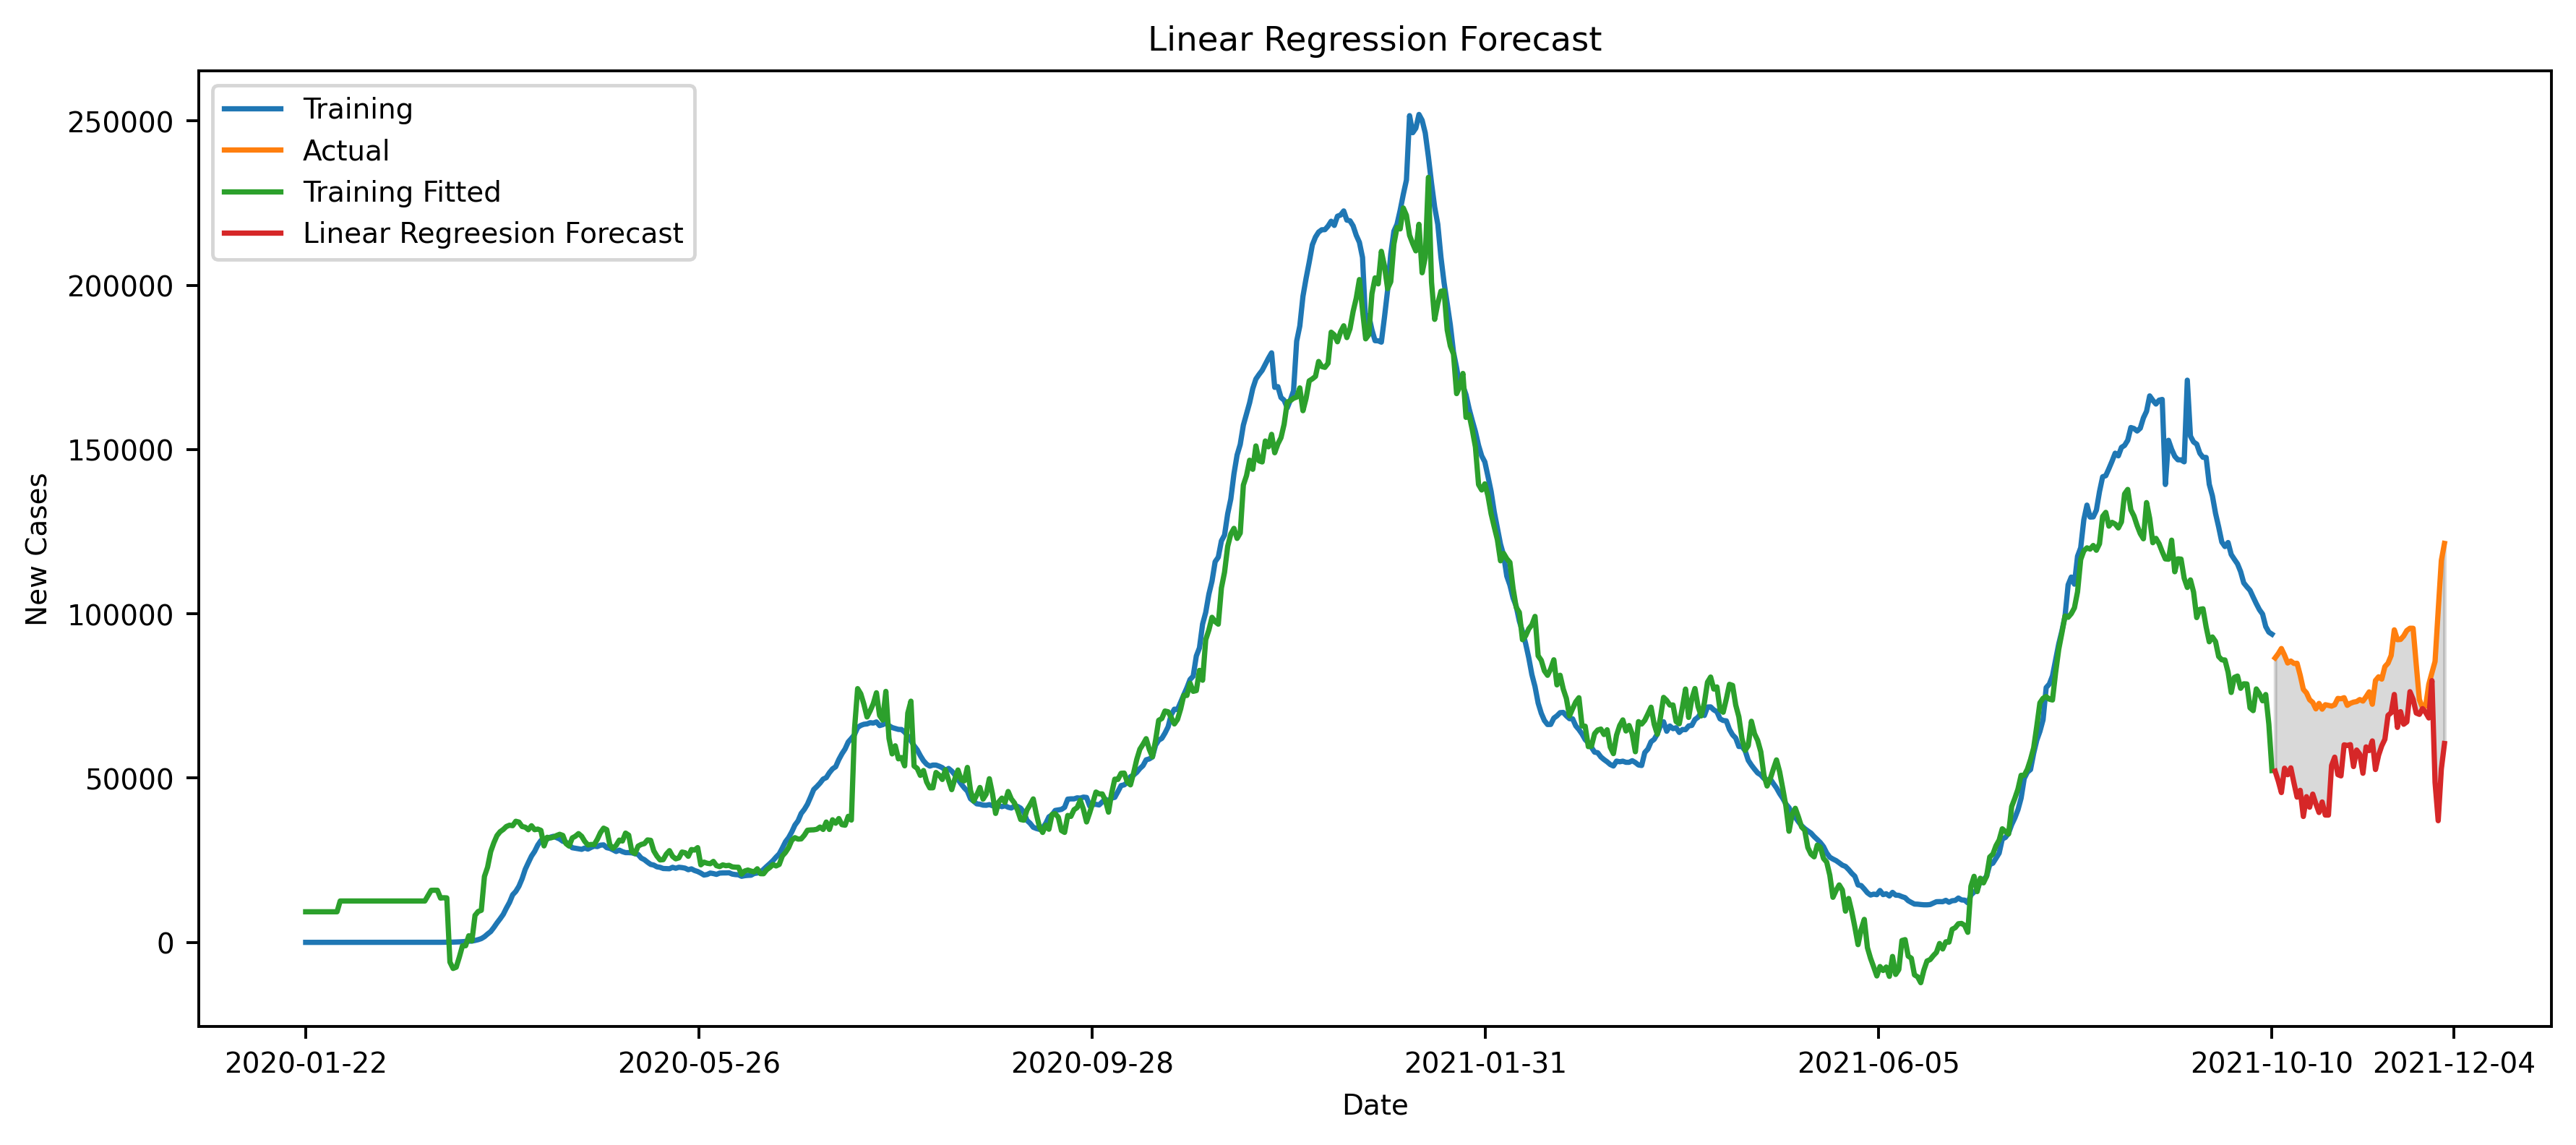

In [895]:
from sklearn.linear_model import LinearRegression
import pickle
# baseline: linear regression
param_grid_lr =  {
        }

lr_fit, lr_trian, lr_pred = MLpipe_KFold_RMSE(X_USA, Y_USA, X_USA_test, 
                                              Y_USA_test, LinearRegression, param_grid_lr)
filename = '../results/LinearModel.sav'
pickle.dump(lr_fit, open(filename, 'wb'))
dates = ['2020-01-22','2020-05-26', '2020-09-28','2021-01-31','2021-06-05', '2021-10-10', '2021-12-04']
pos = [0, 125/683, 250/683, 375/683, 500/683, 625/683, 1]
xticks_pos = [pos[i]*685 for i in range(len(pos))]

fitted_lr_train = pd.Series(lr_trian, index=Y_USA.index)
fitted_lr_test = pd.Series(lr_pred, index=Y_USA_test.index)
fig, ax = plt.subplots(1,1,figsize=(12, 5), dpi=350)
plt.plot(Y_USA, label='Training')
plt.plot(Y_USA_test, label='Actual')
plt.plot(fitted_lr_train, label='Training Fitted')
plt.plot(fitted_lr_test, label='Linear Regreesion Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.fill_between(Y_USA_test.index, fitted_lr_test, Y_USA_test, 
                     color='k', alpha=.15)
plt.title("Linear Regression Forecast")
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.rcParams.update({'font.size': 8})
plt.xticks(xticks_pos, dates)
#ax.set_xticks(ax.get_xticks()[::70])
plt.savefig('../figures/LinearModel.png', dpi=300)
plt.show()

In [800]:
param_grid_ridge =  {
    'alpha': np.logspace(-3,1,10),
    'max_iter': [1000000]
        }

ridge_ft, ridge_train, ridge_test = MLpipe_KFold_RMSE(X_USA, 
                                                      Y_USA, X_USA_test, Y_USA_test, Lasso, param_grid_ridge)

Mean val score: 25237.71078312955
Standard deviation: 14249.108030754098
Best params: {'max_iter': 1000000, 'alpha': 10.0}
Best Test RMSE: 27784.280988279737


## SVR

In [825]:
from sklearn.svm import SVR

param_grid_svr =  {
    'gamma': np.logspace(-3,3,10), 
    'C': np.logspace(2,4,10)
        }

svr_ft, svr_train, svr_test = MLpipe_KFold_RMSE(X_USA, Y_USA, X_USA_test, Y_USA_test, SVR, param_grid_svr)

Mean val score: 63143.47077097302
Standard deviation: 43978.68405778437
Best params: {'gamma': 0.021544346900318832, 'C': 5994.8425031894085}
Best Test RMSE: 22351.243642356305


In [896]:
filename = '../results/SVRModel.sav'
pickle.dump(svr_ft, open(filename, 'wb'))

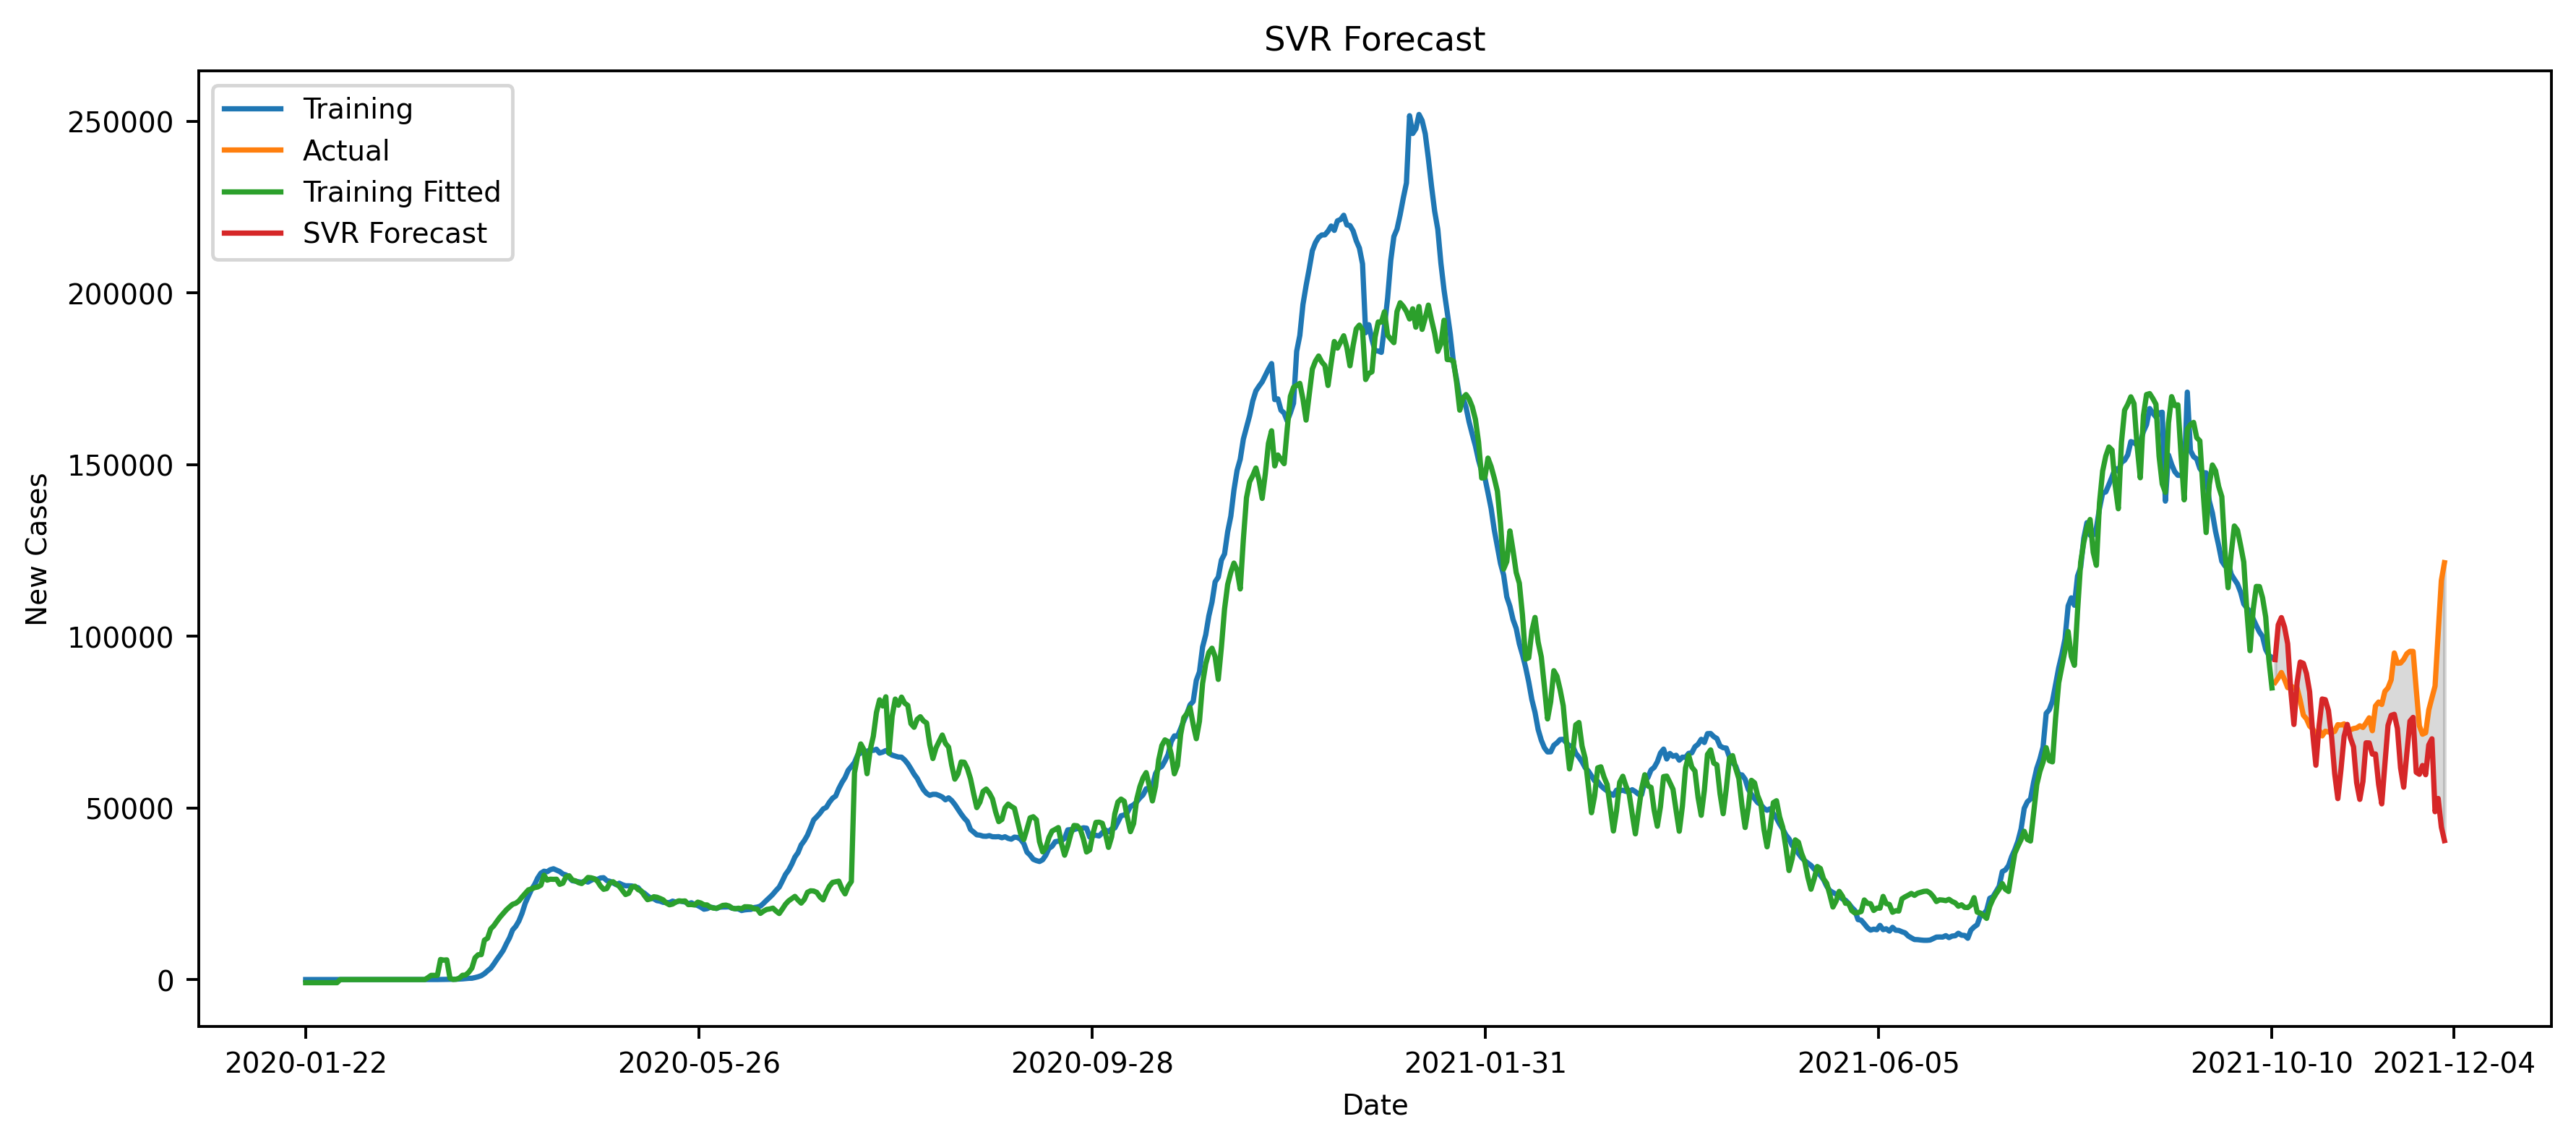

In [827]:
fitted_svr_train = pd.Series(svr_train, index=Y_USA.index)
fitted_svr_test = pd.Series(svr_test, index=Y_USA_test.index)
fig, ax = plt.subplots(1,1,figsize=(12, 5), dpi=350)
plt.plot(Y_USA, label='Training')
plt.plot(Y_USA_test, label='Actual')
plt.plot(fitted_svr_train, label='Training Fitted')
plt.plot(fitted_svr_test, label='SVR Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.fill_between(Y_USA_test.index, fitted_svr_test, Y_USA_test, 
                     color='k', alpha=.15)
plt.title("SVR Forecast")
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.rcParams.update({'font.size': 8})
plt.xticks(xticks_pos, dates)
#ax.set_xticks(ax.get_xticks()[::70])
plt.savefig('../figures/SVRModel.png', dpi=300)
plt.show()

## xgboost

In [828]:
# XGBOOST
# X_USA_xgb, X_USA_test_xgb, Y_USA, Y_USA_test
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

param_grid_xbg = {"learning_rate": [0.03],
              "n_estimators": [100],
              "colsample_bytree": [0.7,0.9],
              "subsample": [0.66],
              "max_depth": range(5,10)
              }

def XGB_KFold_RMSE(X, Y, X_test, Y_test, param_grid, n_folds=4):
    XGB = xgboost.XGBRegressor()
    training_total = len(Y)
    each_cv = (int)(training_total / (n_folds+1))
    
    def RMSE(y_true, y_predict):
        return np.sqrt(mean_squared_error(y_true, y_predict))
    
    random_states = 42 # 10 different states
    models = []
    val_scores = []
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        for j in range(n_folds):
            train_index = (j+1) * each_cv
            val_index = (j+2) * each_cv
            if j == n_folds - 1:
                val_index = training_total
            X_train, X_val = X[: train_index], X[train_index:val_index]
            Y_train, Y_val = Y[: train_index], Y[train_index:val_index]
            
            '''scaler = StandardScaler()
            X_train_prep = scaler.fit_transform(X_train)
            X_val_prep = scaler.transform(X_val)
            X_test_prep = scaler.transform(X_test)
            test_series.append(X_test_prep)
            
            df_train = pd.DataFrame(data=X_train_prep,columns=feature_names)
            df_val = pd.DataFrame(data=X_val_prep,columns=feature_names)'''
            
            XGB.set_params(**ParameterGrid(param_grid)[0], seed=42, missing=np.nan, eval_metric=mean_squared_error)
            XGB.fit(X_train,Y_train,early_stopping_rounds=50,eval_set=[(X_val, Y_val)], verbose=False)

            models.append(XGB) # save it
            # calculate train and validation accuracy scores
            Y_val_pred = XGB.predict(X_val)
            val_scores.append(RMSE(Y_val,Y_val_pred))
            #print('   ',val_scores[p])
    
    pos = np.argmin(val_scores)
    print('Mean val score:', np.mean(val_scores))
    print('Standard deviation:', np.std(val_scores))
    print("Best params:", ParameterGrid(param_grid)[pos//n_folds])
    best_model = models[pos]
    Y_test_pred = best_model.predict(X_test)
    print('Best Test RMSE:', RMSE(Y_test, Y_test_pred))

    return best_model, best_model.predict(X), Y_test_pred


In [829]:
xgb_ft, xgb_train, xgb_test = XGB_KFold_RMSE(X_USA_xgb, Y_USA, X_USA_test_xgb, Y_USA_test, param_grid_xbg)

Mean val score: 43910.81731991556
Standard deviation: 44963.51421246133
Best params: {'subsample': 0.66, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.03, 'colsample_bytree': 0.7}
Best Test RMSE: 19740.743165990454


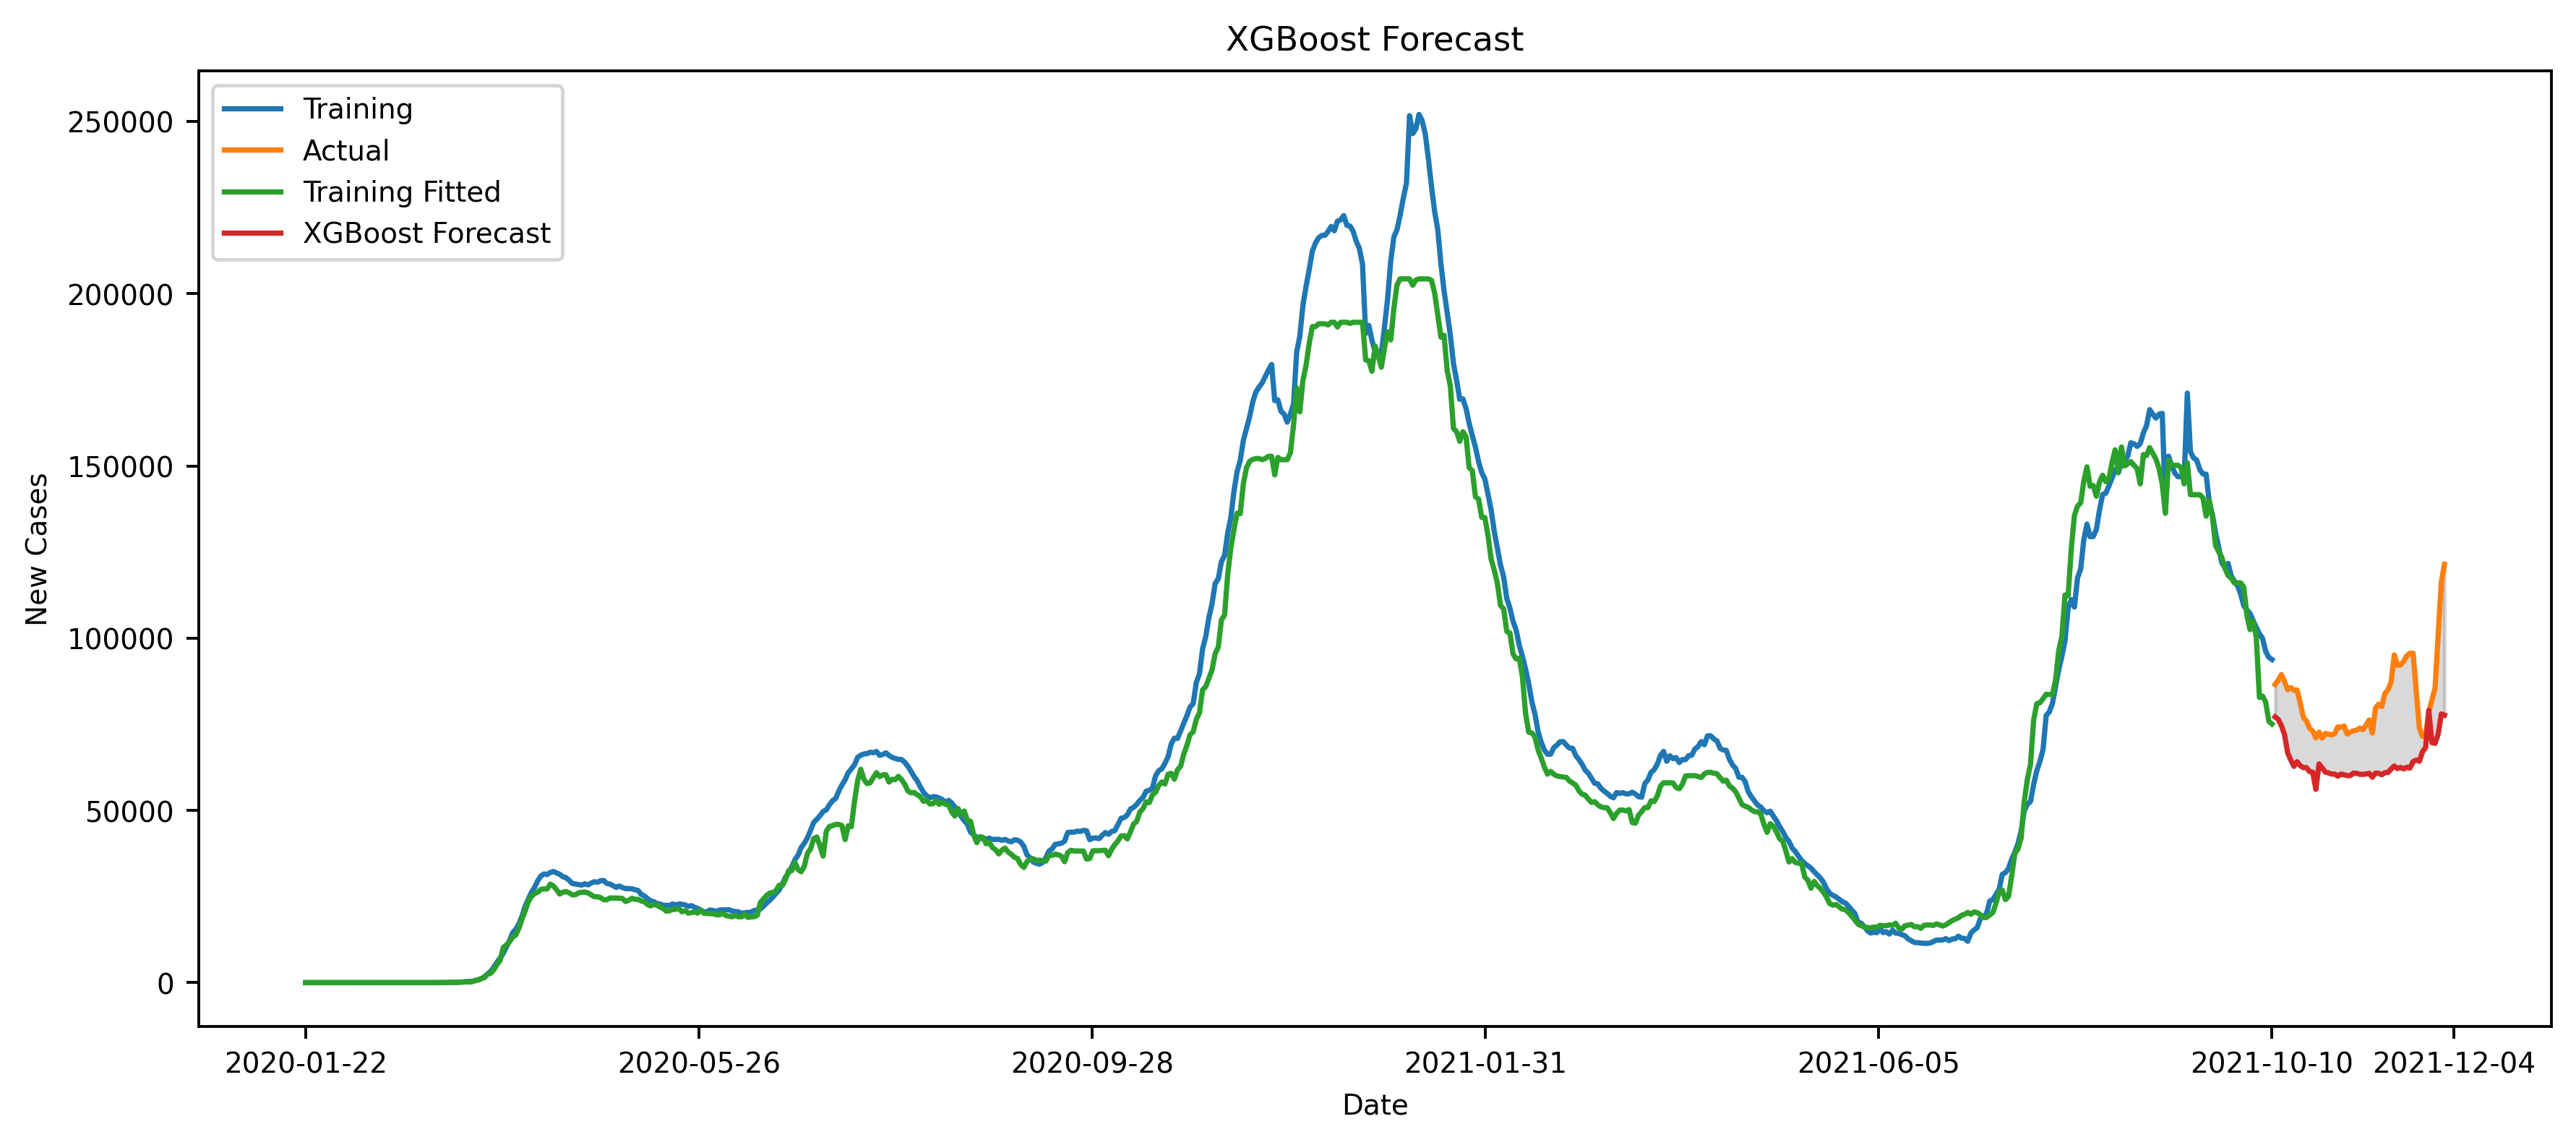

In [897]:
filename = '../results/XGBModel.sav'
pickle.dump(xgb_ft, open(filename, 'wb'))

fitted_xgb_train = pd.Series(xgb_train, index=Y_USA.index)
fitted_xgb_test = pd.Series(xgb_test, index=Y_USA_test.index)
fig, ax = plt.subplots(1,1,figsize=(12, 5), dpi=350)
plt.plot(Y_USA, label='Training')
plt.plot(Y_USA_test, label='Actual')
plt.plot(fitted_xgb_train, label='Training Fitted')
plt.plot(fitted_xgb_test, label='XGBoost Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.fill_between(Y_USA_test.index, fitted_xgb_test, Y_USA_test, 
                     color='k', alpha=.15)
plt.title("XGBoost Forecast")
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.rcParams.update({'font.size': 8})
plt.xticks(xticks_pos, dates)
#ax.set_xticks(ax.get_xticks()[::70])
plt.savefig('../figures/XGBoostModel.png', dpi=300)
plt.show()

[0.0012028  0.01016562 0.03406632 0.15110241 0.29213312 0.48730037
 0.00547026 0.01370521 0.0048539  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


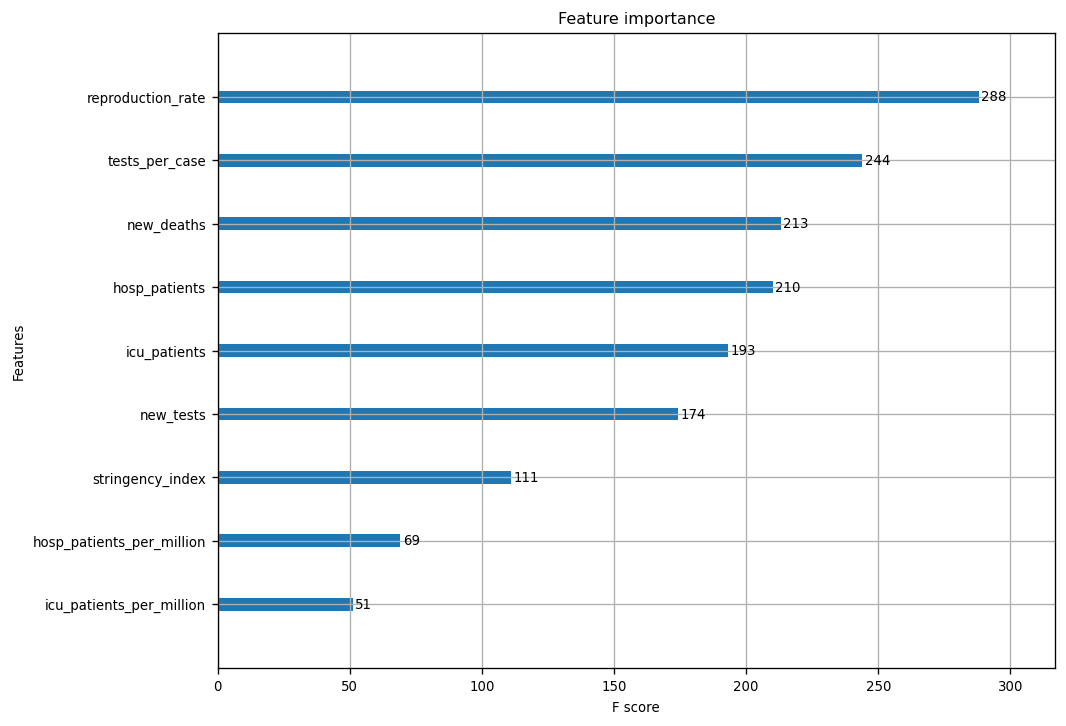

In [834]:
from xgboost import plot_importance
print(xgb_ft.feature_importances_)
# plot feature importance
plot_importance(xgb_ft)
plt.show()

In [870]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(xgb_ft)
# transform the test set
shap_values = explainer.shap_values(X_USA_test)
print(np.shape(shap_values))

(55, 23)


In [835]:
print(explainer.expected_value) 
shap.force_plot(explainer.expected_value, shap_values, 
               features = X_USA_test,feature_names = X_USA_test.columns)

60244.39


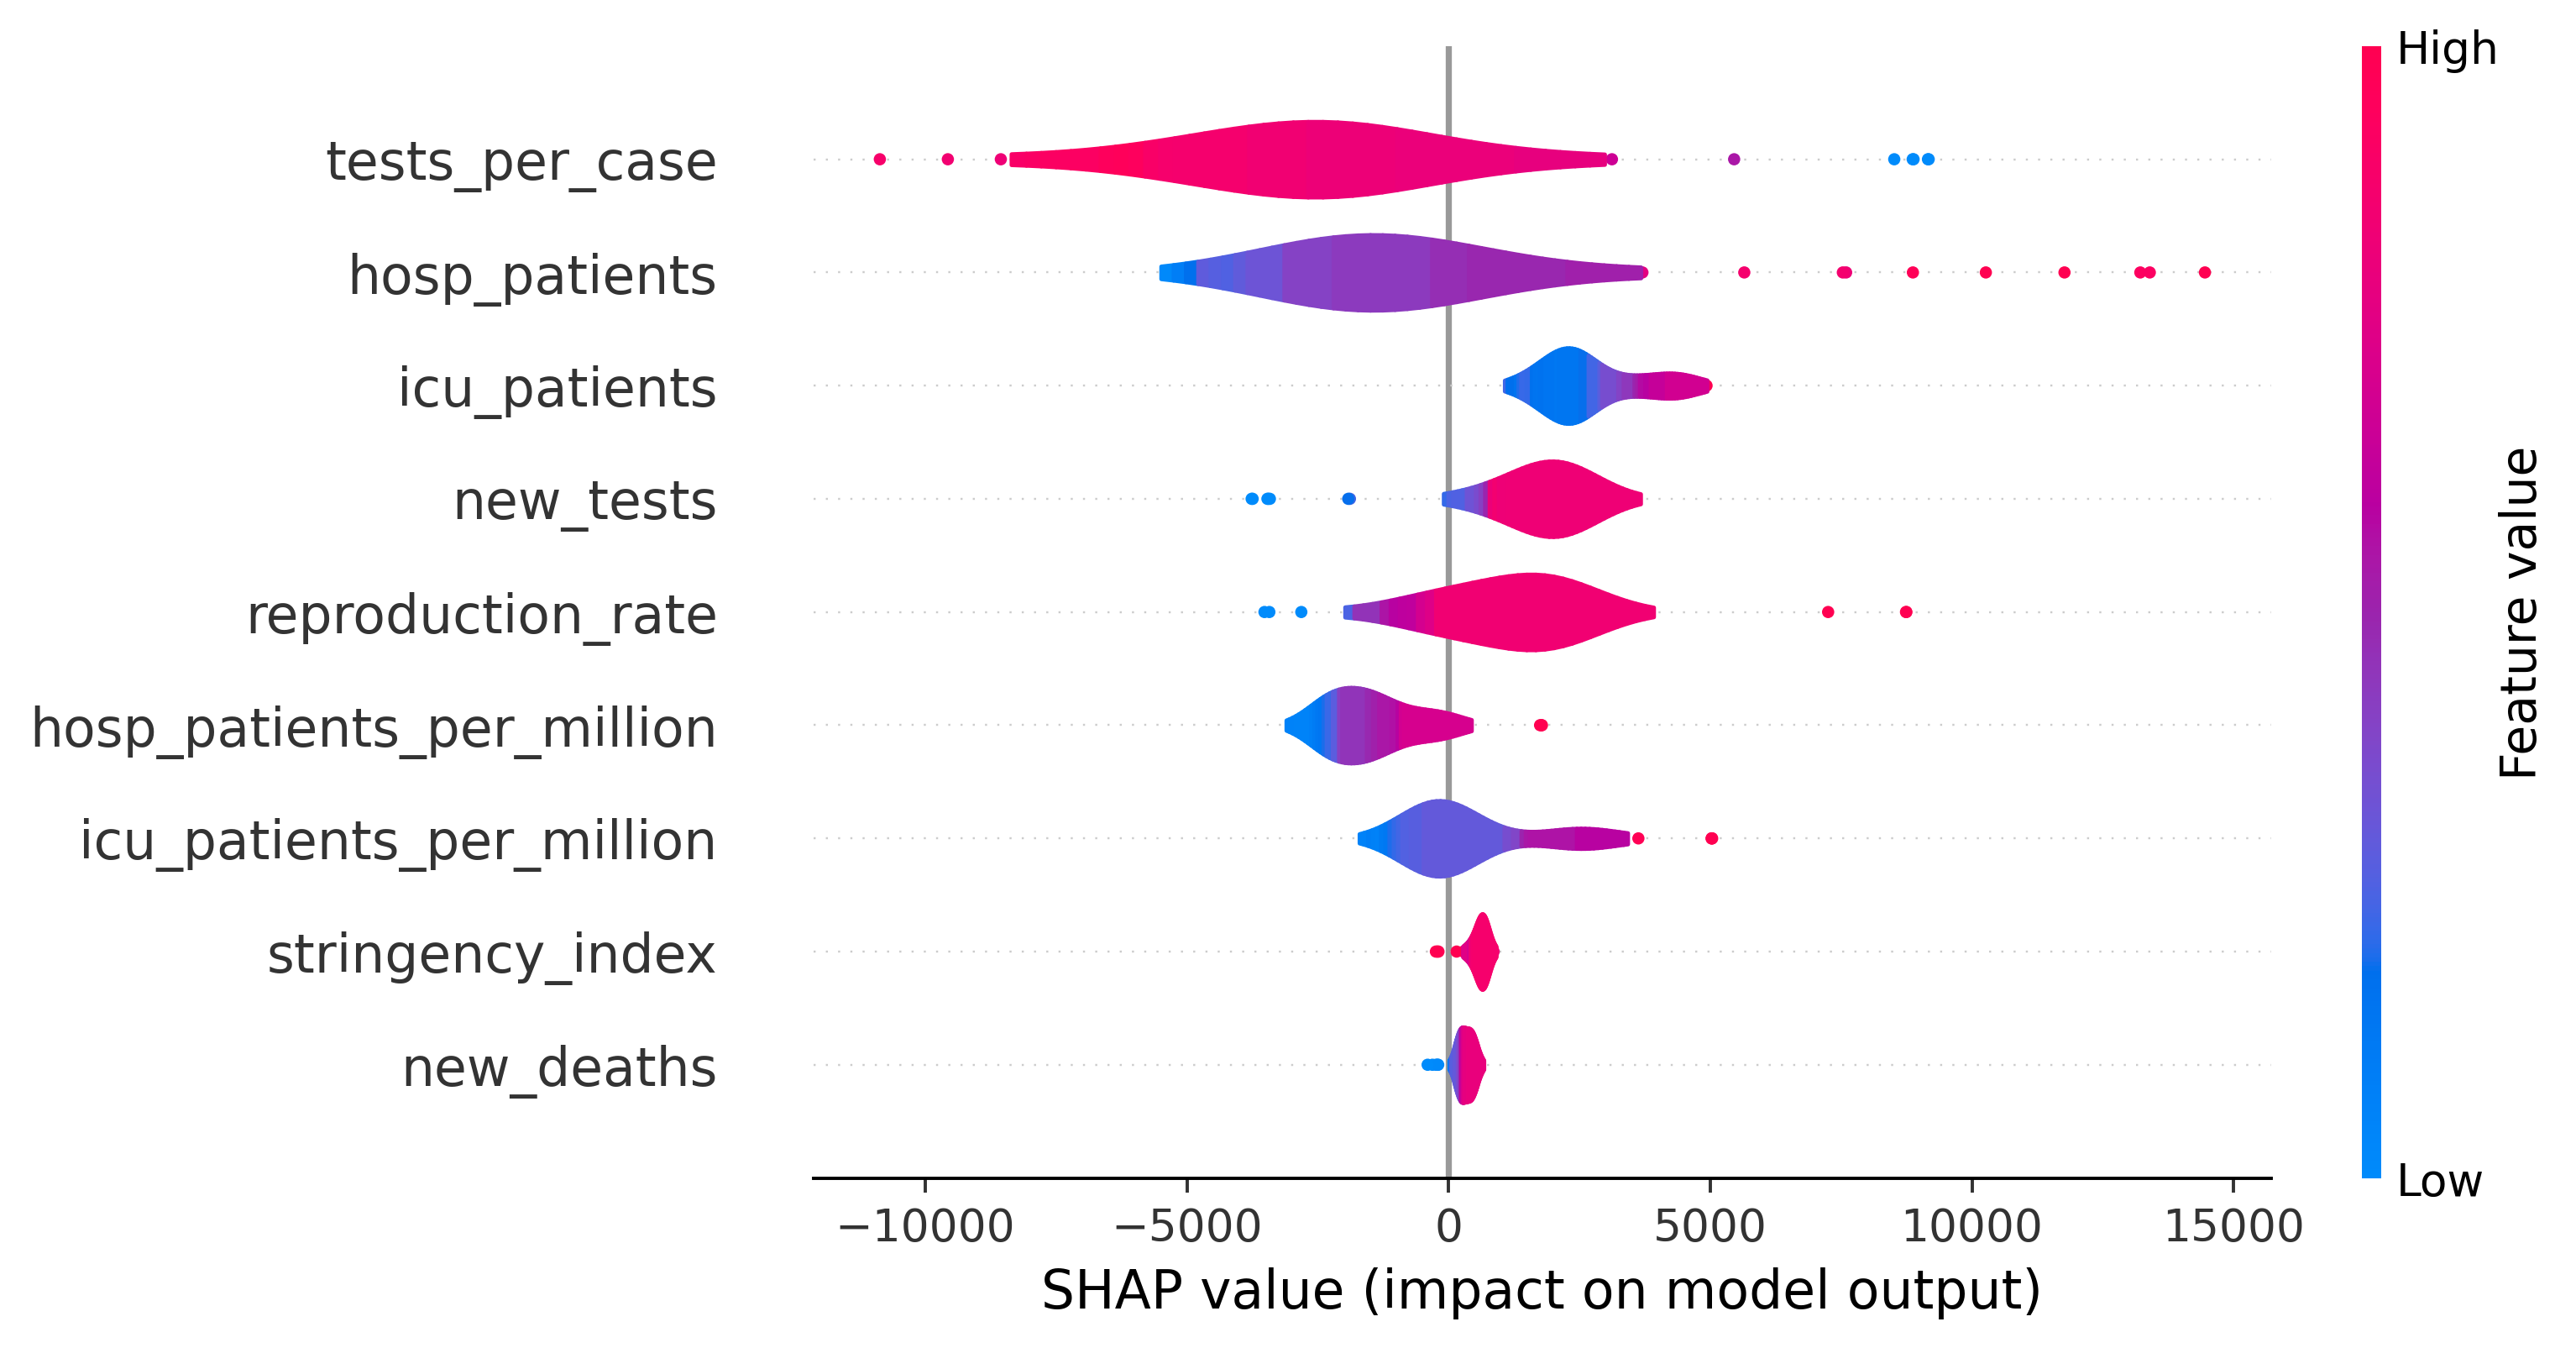

In [893]:
plt.figure(figsize=(14, 8), dpi=350)
shap.summary_plot(shap_values, X_USA_test,feature_names = X_USA_test.columns, 
                  max_display=9, plot_type='violin',
                        show=False)
plt.savefig('../figures/shap.png')
#plt.show()

In [880]:
help(shap.summary_plot)

Help on function summary_legacy in module shap.plots._beeswarm:

summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f978abfb790>, auto_size_plot=None, use_log_scale=False)
    Create a SHAP beeswarm plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names :